
# Problem



**Kredi riski sınıflandırmak üzere bir makine öğrenmesi modeli kurmak.**

**Veri Seti Hikayesi**

Veri seti kaynağı: https://archive.ics.uci.edu/ml/datasets/statlog+(german+credit+data)

- **1000 bireye ait gözlemler var.**

**Değişkenler**

- **Age**: Yaş

- **Sex**: Cinsiyet

- **Job**: Meslek-Yetenek (0 - unskilled and non-resident, 1 - unskilled and resident, 2 - skilled, 3 - highly skilled)

- **Housing**: Barınma Durumu (own, rent, or free)

- **Saving accounts**: Tasarruf Durumu (little, moderate, quite rich, rich)

- **Checking account**: Vadesiz Hesap (DM - Deutsch Mark)

- **Credit amount**: Kredi Miktarı (DM)

- **Duration**: Süre (month)

- **Purpose**: Amaç (car, furniture/equipment, radio/TV, domestic appliances, repairs, education, business, vacation/others)

- **Risk**: Risk (Good, Bad Risk)
    



In [1]:
#Kütüphanelerin yuklenmesi

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression  
from sklearn.neighbors import KNeighborsClassifier  
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score, GridSearchCV
from scipy.stats import shapiro
import warnings
warnings.filterwarnings("ignore")

%config InlineBackend.figure_format = 'retina'


In [2]:
#verinin yuklenmesi
df = pd.read_csv("../input/kredi-riski/credit_risk kopyas.csv", index_col=0)
df.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,49,male,1,own,little,NaN,2096,12,education,good
3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,53,male,2,free,little,little,4870,24,car,bad


In [3]:
df.Age.min()

19

In [4]:
#ilk 5 gozlem
df.head()

#son 5 gozlem
df.tail()

#verinin olculeri
df.shape

#veri hakkındakı bilgiler
df.info()

#veride bulunan degiskenlerin isimleri
df.columns

#verinin betimsel istatistiği
df.describe().T

#Eksik degerin sorgulanması(Saving accounts ve Checking account  degiskenlerinde eksik degerler bulıunmaktadır.)
df.isnull().values.any()
df.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Age               1000 non-null   int64 
 1   Sex               1000 non-null   object
 2   Job               1000 non-null   int64 
 3   Housing           1000 non-null   object
 4   Saving accounts   817 non-null    object
 5   Checking account  606 non-null    object
 6   Credit amount     1000 non-null   int64 
 7   Duration          1000 non-null   int64 
 8   Purpose           1000 non-null   object
 9   Risk              1000 non-null   object
dtypes: int64(4), object(6)
memory usage: 85.9+ KB


Age                   0
Sex                   0
Job                   0
Housing               0
Saving accounts     183
Checking account    394
Credit amount         0
Duration              0
Purpose               0
Risk                  0
dtype: int64

In [5]:
#yeni degiskenler turetilmesi
df["faiz_yuzdesi"] = (df.Duration * 1.25) / 100
df["toplam_borc"] =(df["Credit amount"]) + (df["Credit amount"] * df["faiz_yuzdesi"])
df["faiz_tutari"] = (df["toplam_borc"] - df["Credit amount"])
df["yas_sure"] = (df.Age * 12) + (df.Duration)
df["ust_yas"] = (85 * 12) - (df["yas_sure"])
df["c_d"] = (df["Credit amount"] * df["Duration"])
#df["c_d_faiz_tutari"] = (df["c_d"] * df["faiz_tutari"] )
df["d_a"] = (df["Credit amount"] * df["Age"])
df.loc[df["Job"] == 0 , "Job" ] = 1
df.loc[df["Saving accounts"] == "quite rich" , "Saving accounts" ] = "rich"

df.head(10)

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk,faiz_yuzdesi,toplam_borc,faiz_tutari,yas_sure,ust_yas,c_d,d_a
0,67,male,2,own,NaN,little,1169,6,radio/TV,good,0.075,1256.675,87.675,810,210,7014,78323
1,22,female,2,own,little,moderate,5951,48,radio/TV,bad,0.600,9521.600,3570.600,312,708,285648,130922
2,49,male,1,own,little,NaN,2096,12,education,good,0.150,2410.400,314.400,600,420,25152,102704
3,45,male,2,free,little,little,7882,42,furniture/equipment,good,0.525,12020.050,4138.050,582,438,331044,354690
4,53,male,2,free,little,little,4870,24,car,bad,0.300,6331.000,1461.000,660,360,116880,258110
5,35,male,1,free,NaN,NaN,9055,36,education,good,0.450,13129.750,4074.750,456,564,325980,316925
6,53,male,2,own,rich,NaN,2835,24,furniture/equipment,good,0.300,3685.500,850.500,660,360,68040,150255
7,35,male,3,rent,little,moderate,6948,36,car,good,0.450,10074.600,3126.600,456,564,250128,243180
8,61,male,1,own,rich,NaN,3059,12,radio/TV,good,0.150,3517.850,458.850,744,276,36708,186599
9,28,male,3,own,little,moderate,5234,30,car,bad,0.375,7196.750,1962.750,366,654,157020,146552


In [6]:
#Eksik degerlerin mode ile doldurulması
df["Saving accounts"].fillna(df['Saving accounts'].mode()[0], inplace=True)
df["Checking account"].fillna(df['Checking account'].mode()[0], inplace=True)

In [7]:
#tum sayısal degiskenlerde aykırı deger mevcut
def outlier_thresholds(dataframe, variable):
    quartile1 = dataframe[variable].quantile(0.25)
    quartile3 = dataframe[variable].quantile(0.75)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit


outlier_thresholds(df, "Age")

(4.5, 64.5)

Age : 23


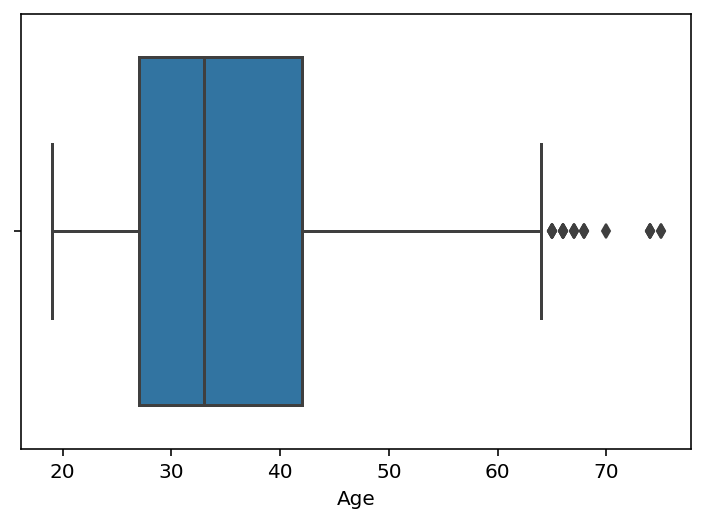

Credit amount : 72


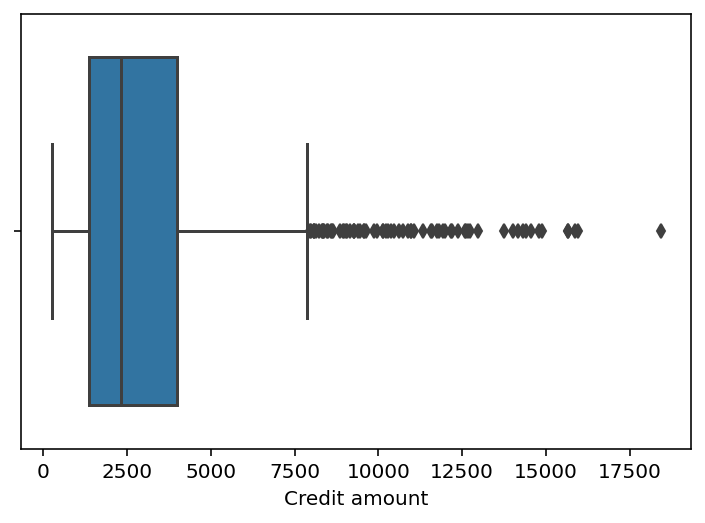

Duration : 70


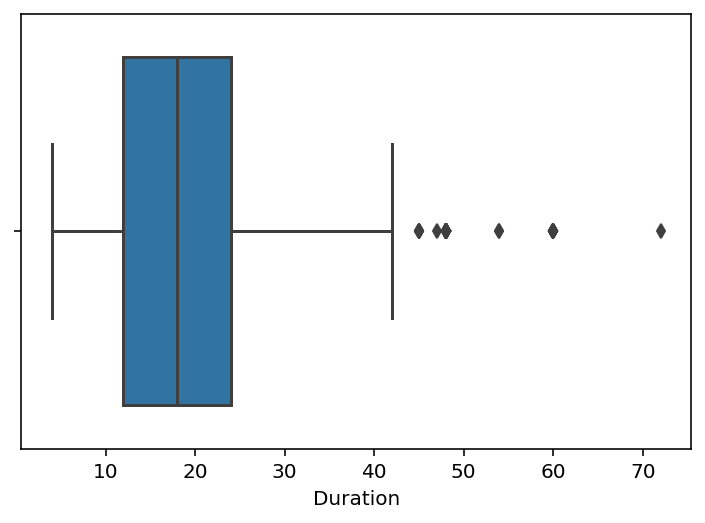

['Age', 'Credit amount', 'Duration']

In [8]:
#Aykırı deger var mı onu sorguluyoruz.
def has_outliers(dataframe, num_col_names, plot=False):
    variable_names = []

    for col in num_col_names:
        low_limit, up_limit = outlier_thresholds(dataframe, col)

        if dataframe[(dataframe[col] > up_limit) | (dataframe[col] < low_limit)].any(axis=None):
            number_of_outliers = dataframe[(dataframe[col] > up_limit) | (dataframe[col] < low_limit)].shape[0]

            print(col, ":", number_of_outliers)
            variable_names.append(col)

            if plot:
                sns.boxplot(x=dataframe[col])
                plt.show()

    return variable_names




has_outliers(df, ["Age","Credit amount","Duration"], plot=True)

In [9]:
#Aykırı degerlerın alt ve ust degerlerinin tespiti.
def outlier_thresholds(dataframe, variable):
    quartile1 = dataframe[variable].quantile(0.05)
    quartile3 = dataframe[variable].quantile(0.95)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

#Baskılama islemi.

def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit



#Baskılama fonksiyonunun uygulanması

a = ["Age" , "Credit amount" ,"faiz_yuzdesi","toplam_borc","faiz_tutari","yas_sure","ust_yas"]
for i in a:
    replace_with_thresholds(df, i)

In [10]:
#Normallik testinin yapılması(Degiskenler normallik varsayımını saglamıyor.)
for i in ["Age" , "Credit amount" ,"faiz_yuzdesi","toplam_borc","faiz_tutari","yas_sure","ust_yas"]:
    
    p = shapiro(df[i])
    print(p)
    if p[1] < 0.05:
        print(i, "nin pvalue degeri 0.05'den kucuk oldugu icin H0 reddedilir.Yani normallik saglanmıyor." )
        
    else:
        print(i, "nin pvalue degeri 0.05'den buyuk oldugu icin H0 reddedilemez.Yani normallik saglanıyor." )
        
    
    
    
    
    

(0.9174707531929016, 6.381270673909361e-23)
Age nin pvalue degeri 0.05'den kucuk oldugu icin H0 reddedilir.Yani normallik saglanmıyor.
(0.7933971881866455, 8.609912964372653e-34)
Credit amount nin pvalue degeri 0.05'den kucuk oldugu icin H0 reddedilir.Yani normallik saglanmıyor.
(0.8997892737388611, 4.908141189598946e-25)
faiz_yuzdesi nin pvalue degeri 0.05'den kucuk oldugu icin H0 reddedilir.Yani normallik saglanmıyor.
(0.7517687678337097, 3.114637801636179e-36)
toplam_borc nin pvalue degeri 0.05'den kucuk oldugu icin H0 reddedilir.Yani normallik saglanmıyor.
(0.6421029567718506, 2.2942058457925905e-41)
faiz_tutari nin pvalue degeri 0.05'den kucuk oldugu icin H0 reddedilir.Yani normallik saglanmıyor.
(0.9233049154281616, 3.779570931562207e-22)
yas_sure nin pvalue degeri 0.05'den kucuk oldugu icin H0 reddedilir.Yani normallik saglanmıyor.
(0.9233077168464661, 3.782896516703129e-22)
ust_yas nin pvalue degeri 0.05'den kucuk oldugu icin H0 reddedilir.Yani normallik saglanmıyor.


In [11]:
#veri setinin uzunlugu
len(df)

1000

In [12]:
#bos deger sorgulama
df.isnull().sum()

Age                 0
Sex                 0
Job                 0
Housing             0
Saving accounts     0
Checking account    0
Credit amount       0
Duration            0
Purpose             0
Risk                0
faiz_yuzdesi        0
toplam_borc         0
faiz_tutari         0
yas_sure            0
ust_yas             0
c_d                 0
d_a                 0
dtype: int64

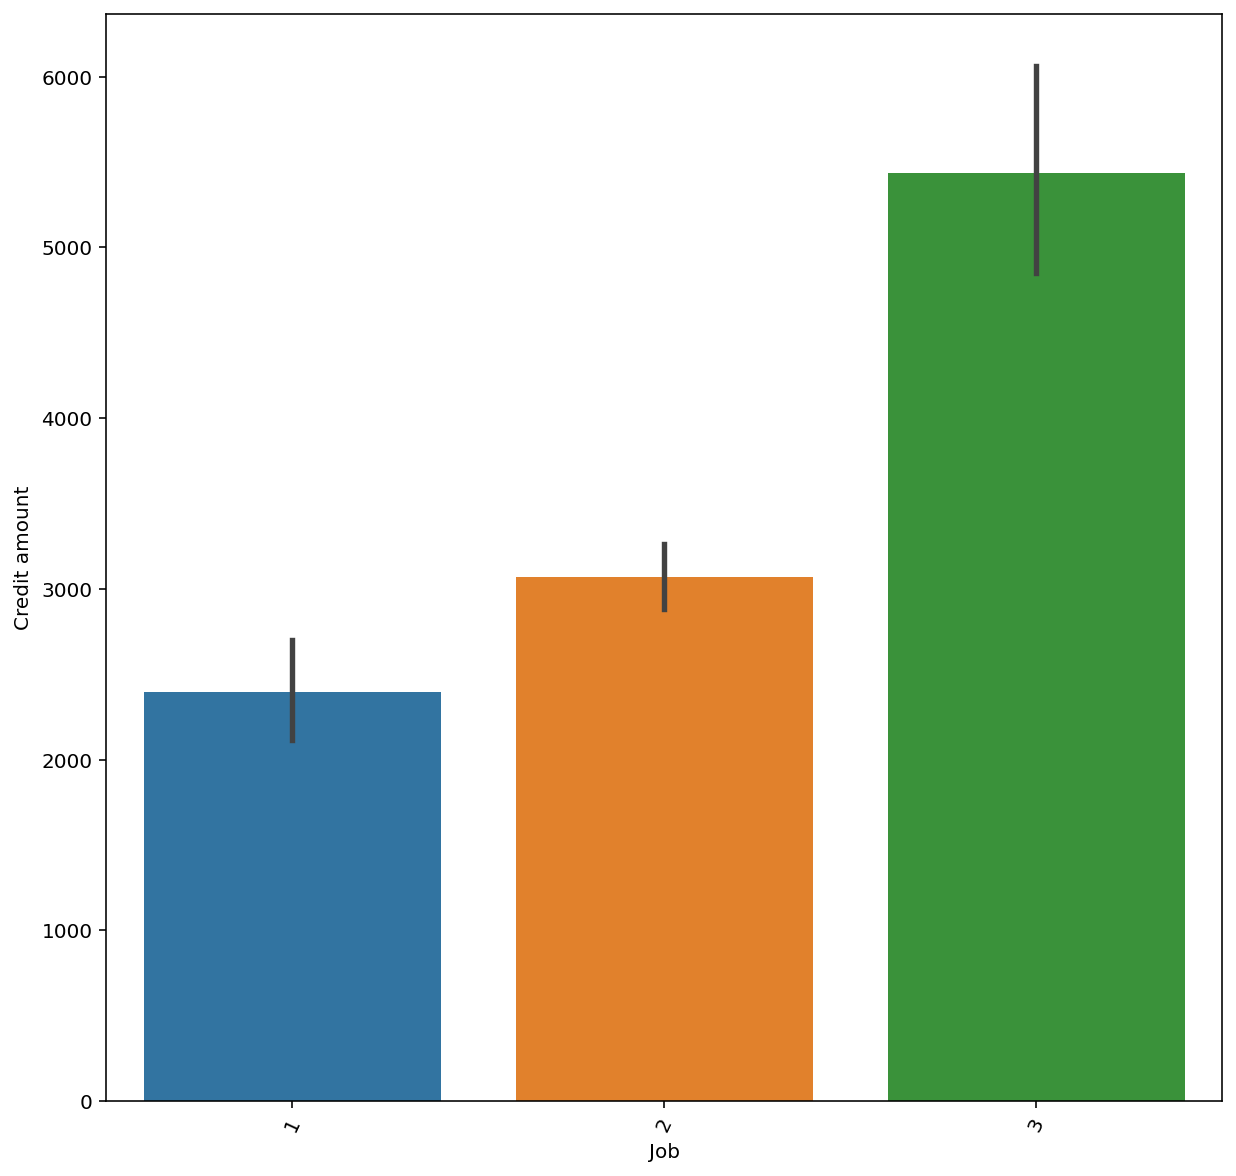

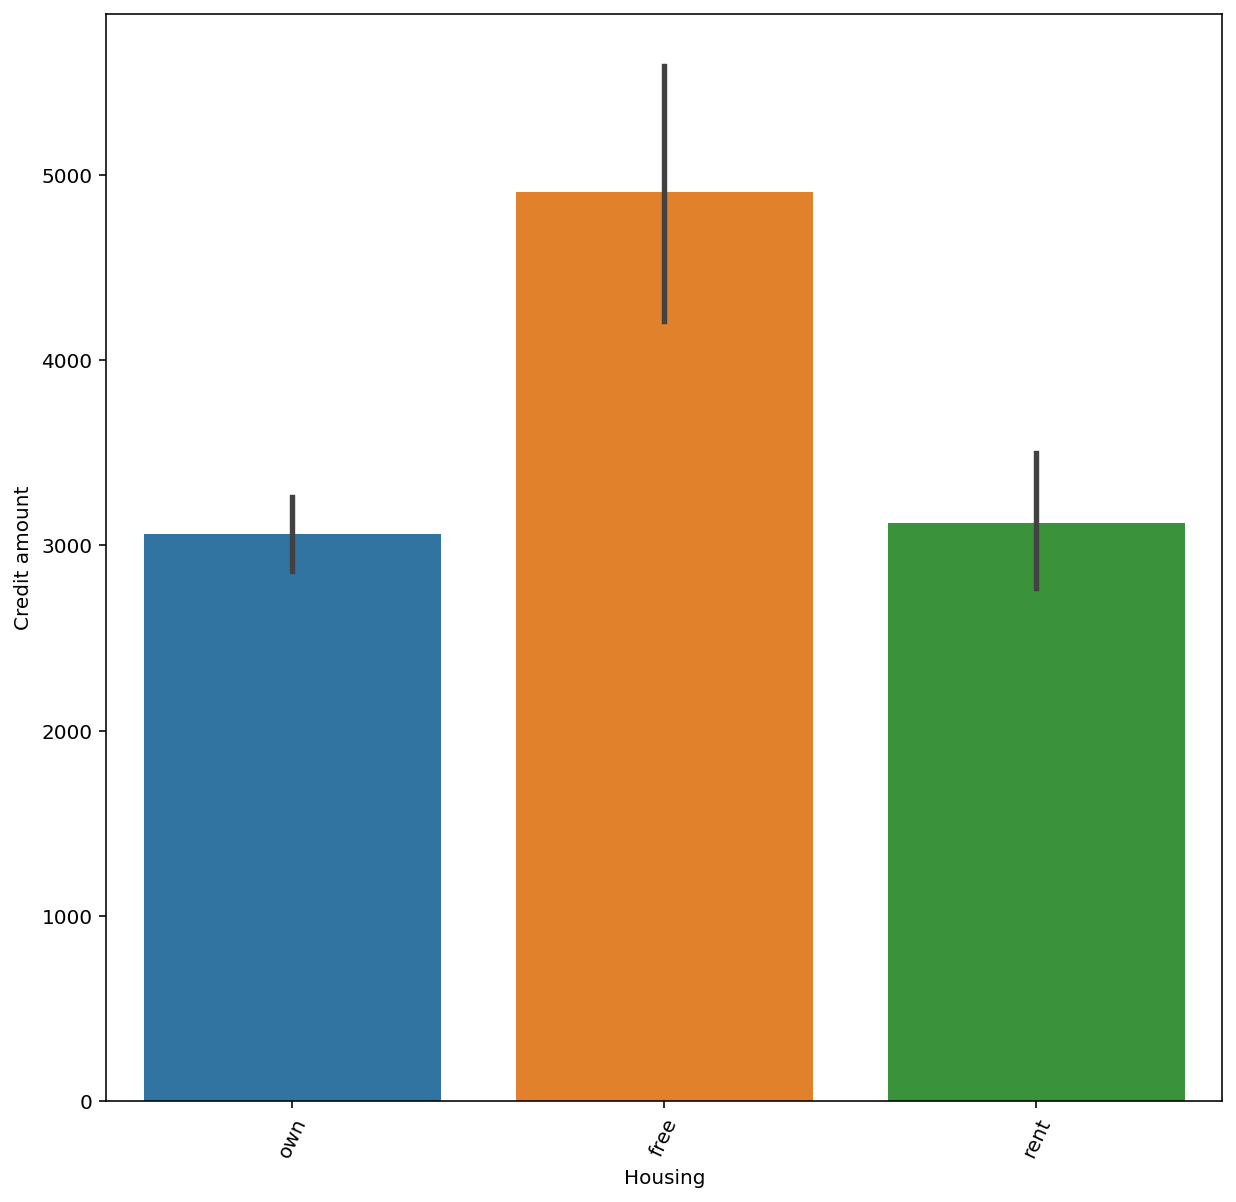

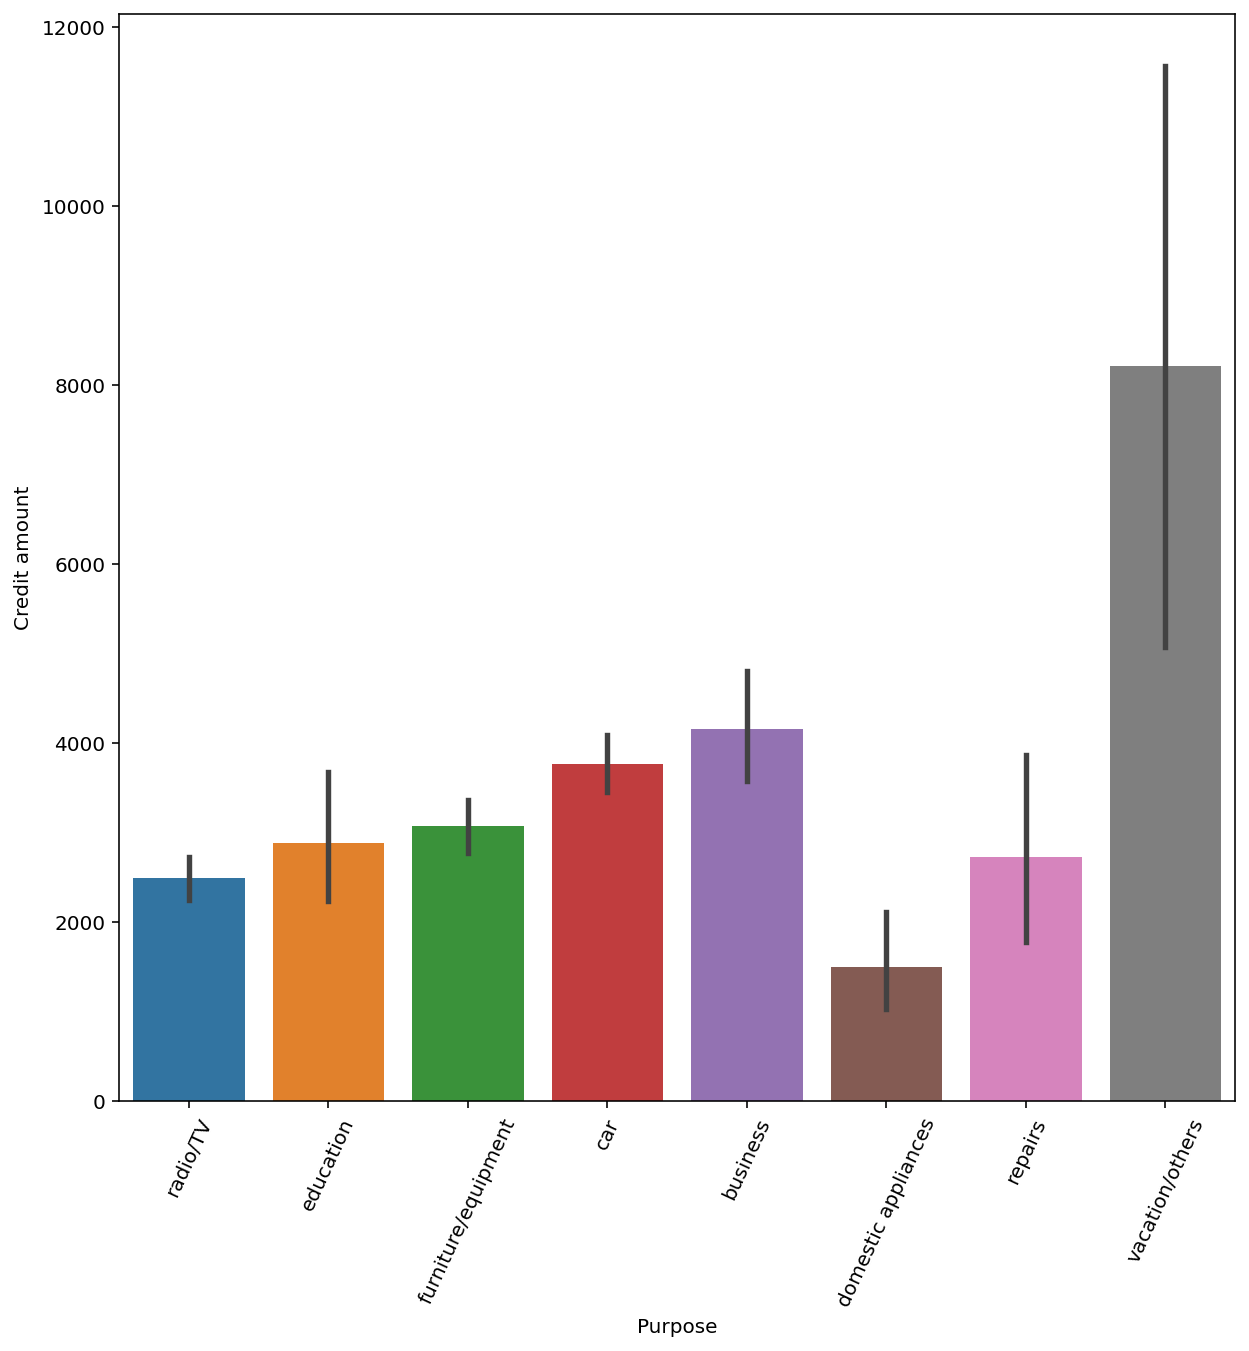

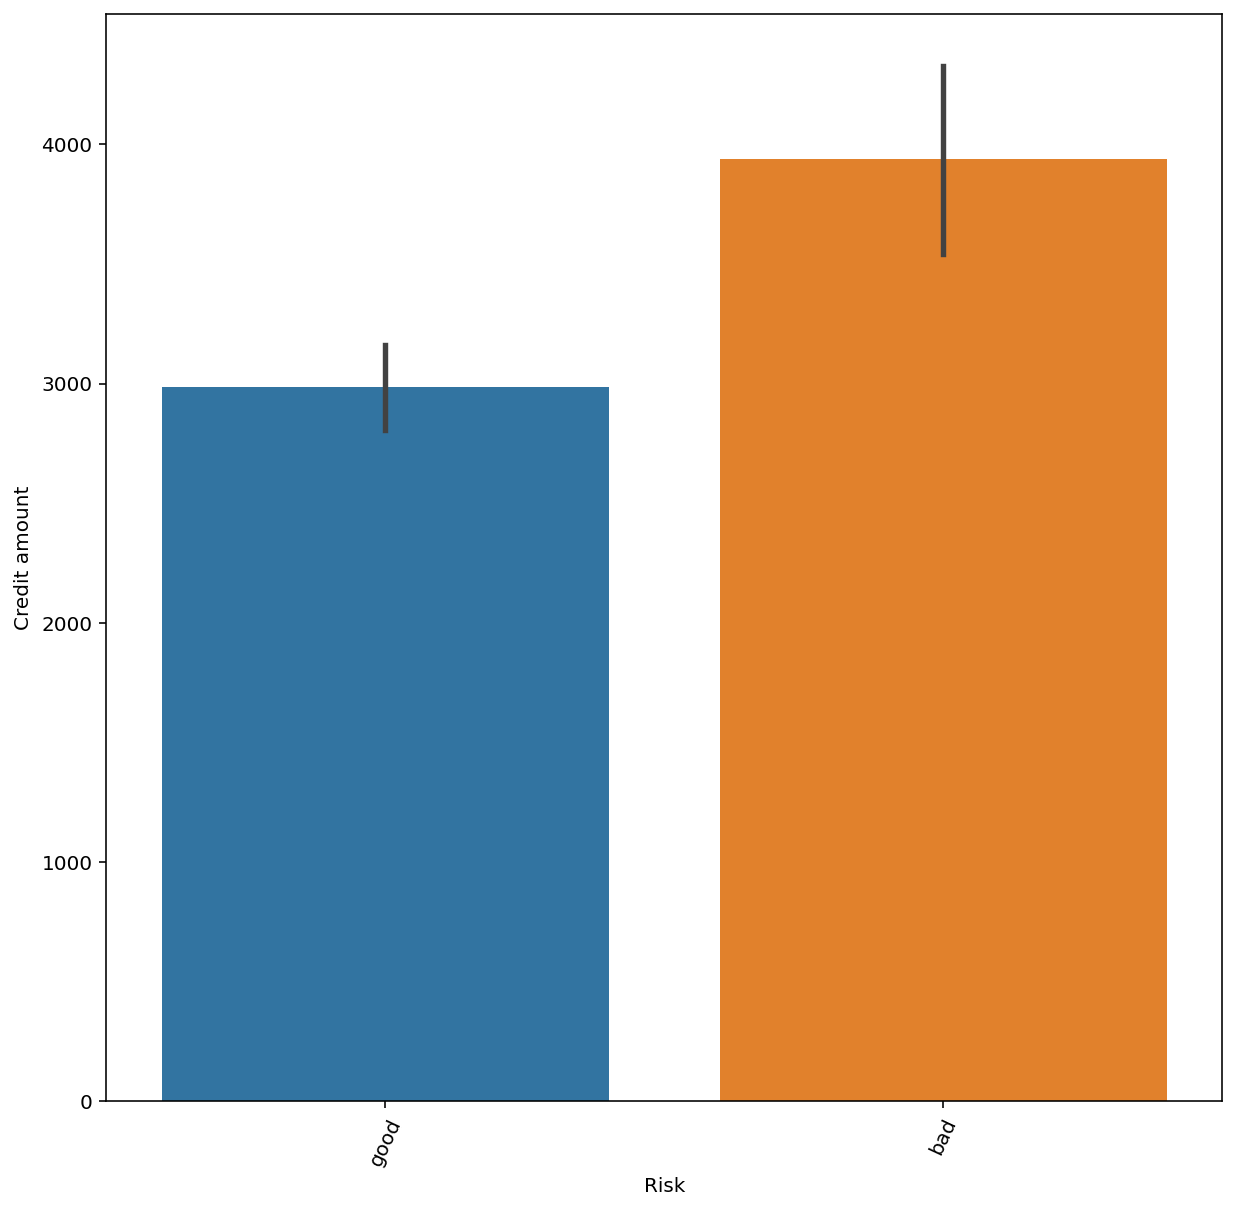

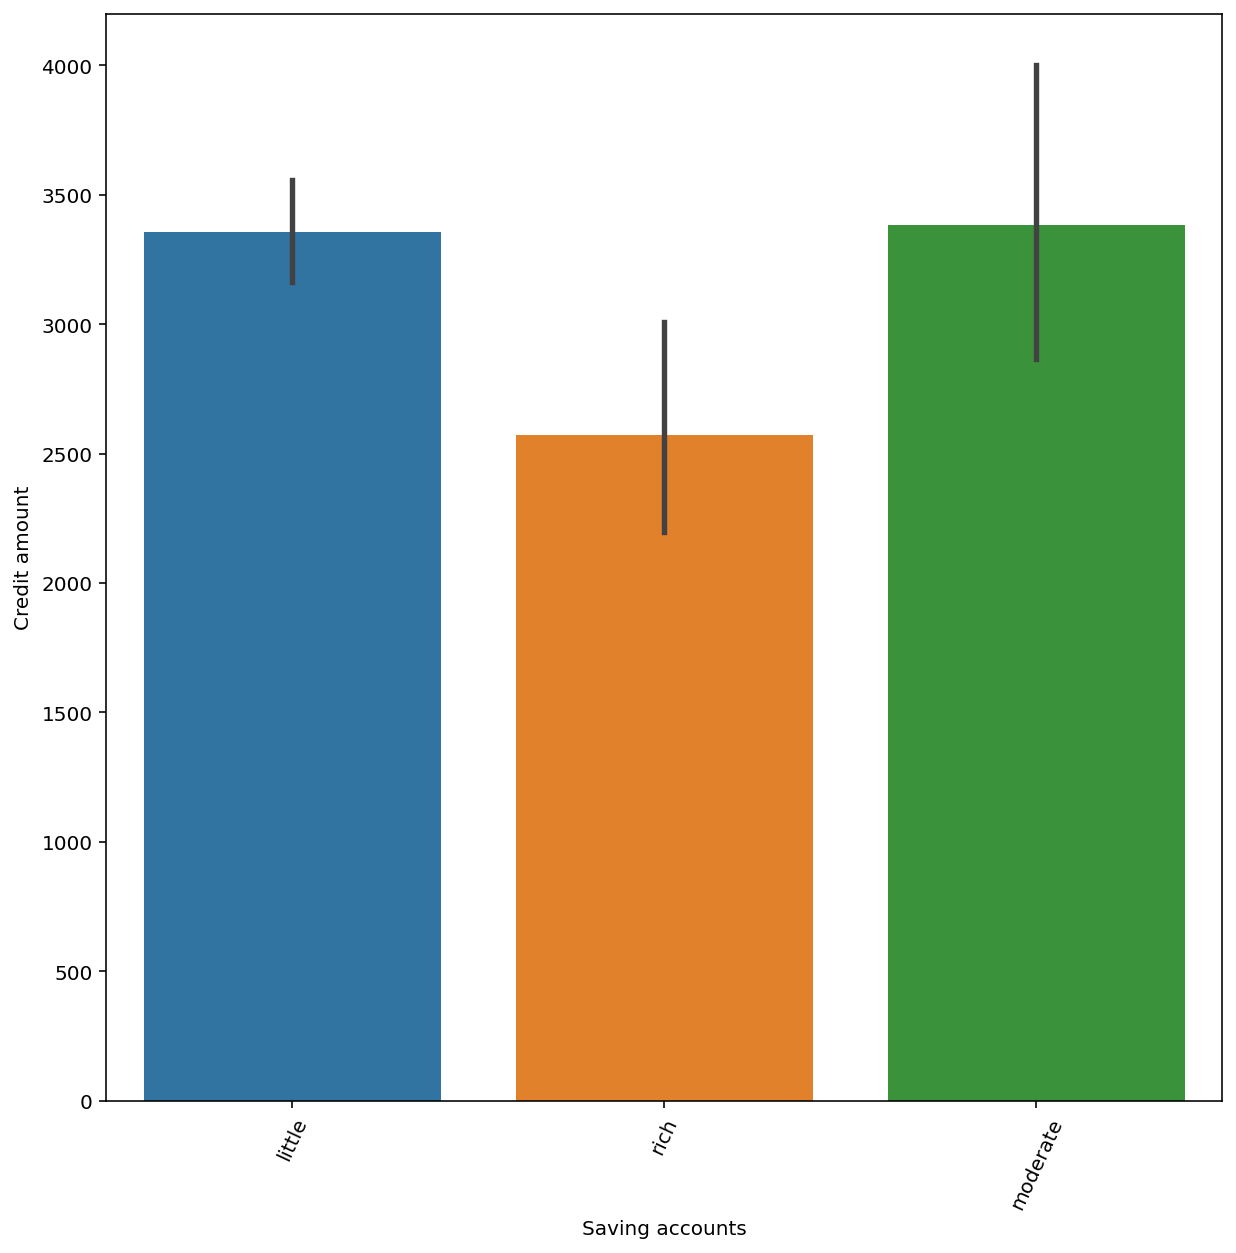

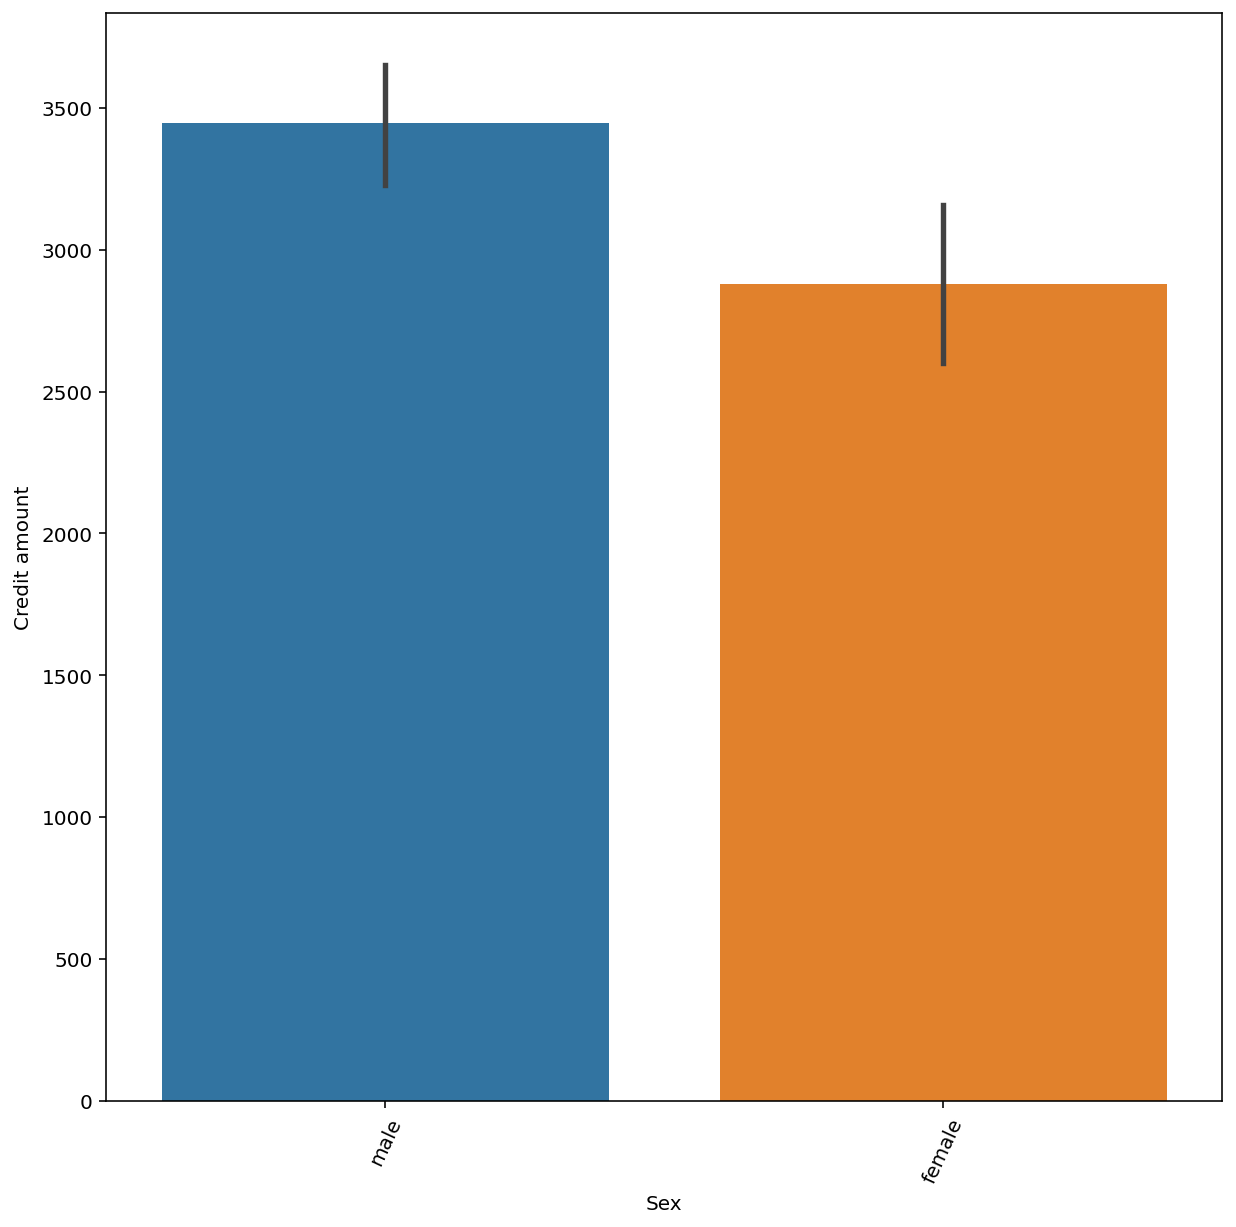

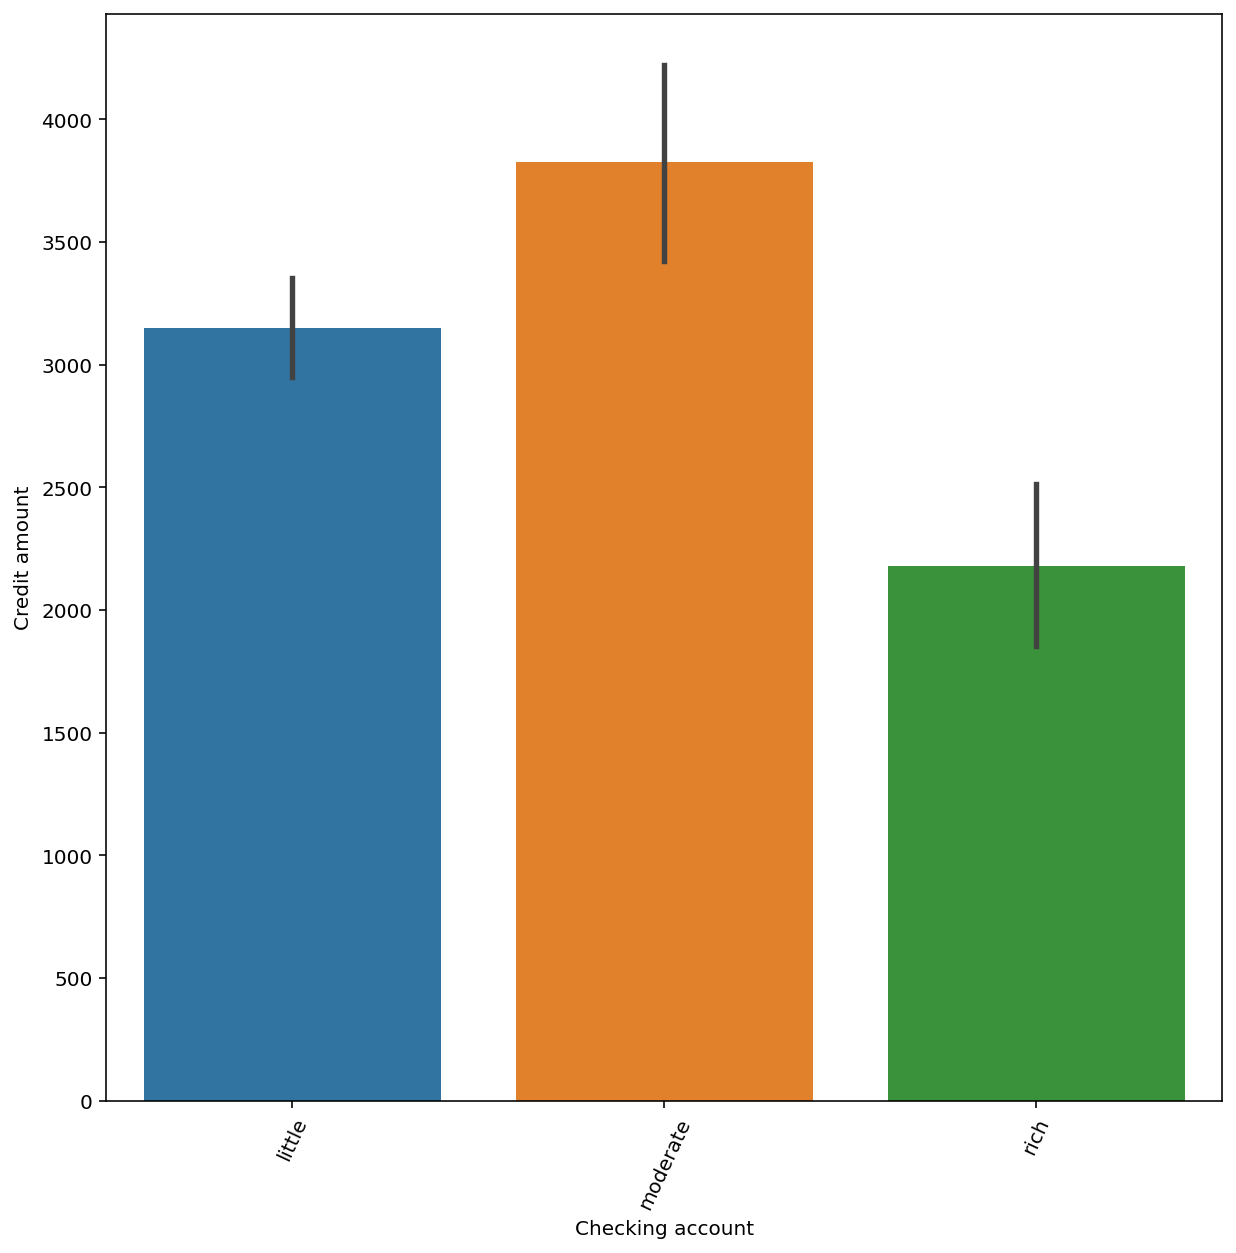

In [13]:
# Kategorik degiskenlerin, Credit amount degiskenine gore  gorsellestirilmesi
cat = ["Job","Housing","Purpose","Risk","Saving accounts","Sex","Checking account"]
for i in cat:
    fig, ax = plt.subplots(figsize=(10,10)) 
    sns.barplot(x= i, y="Credit amount", data=df)
    plt.xticks( rotation = '65')
    plt.show()

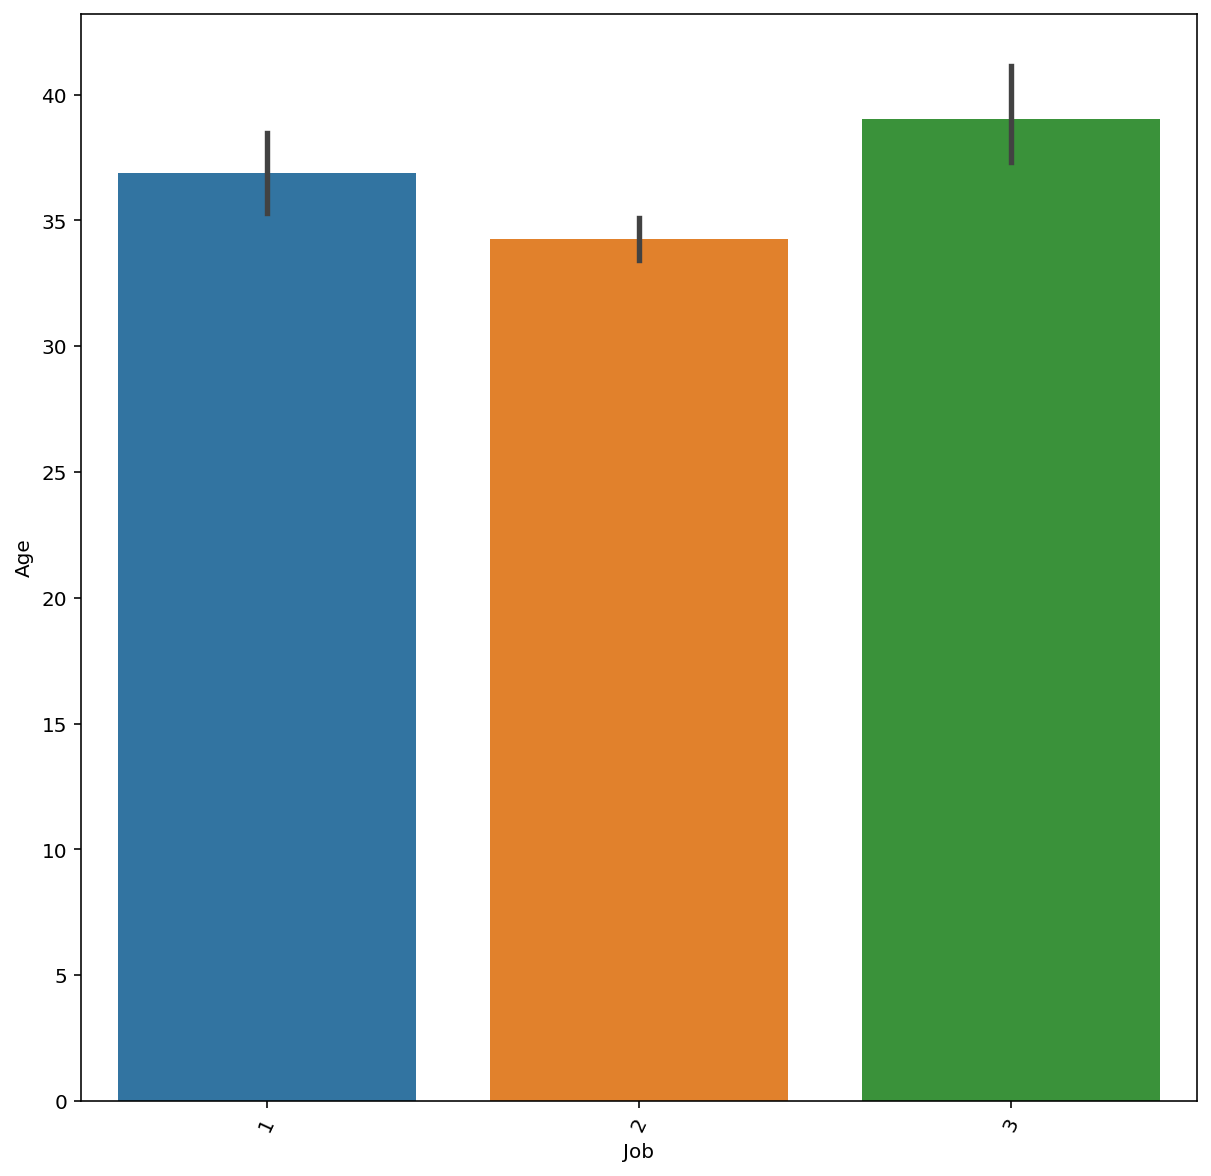

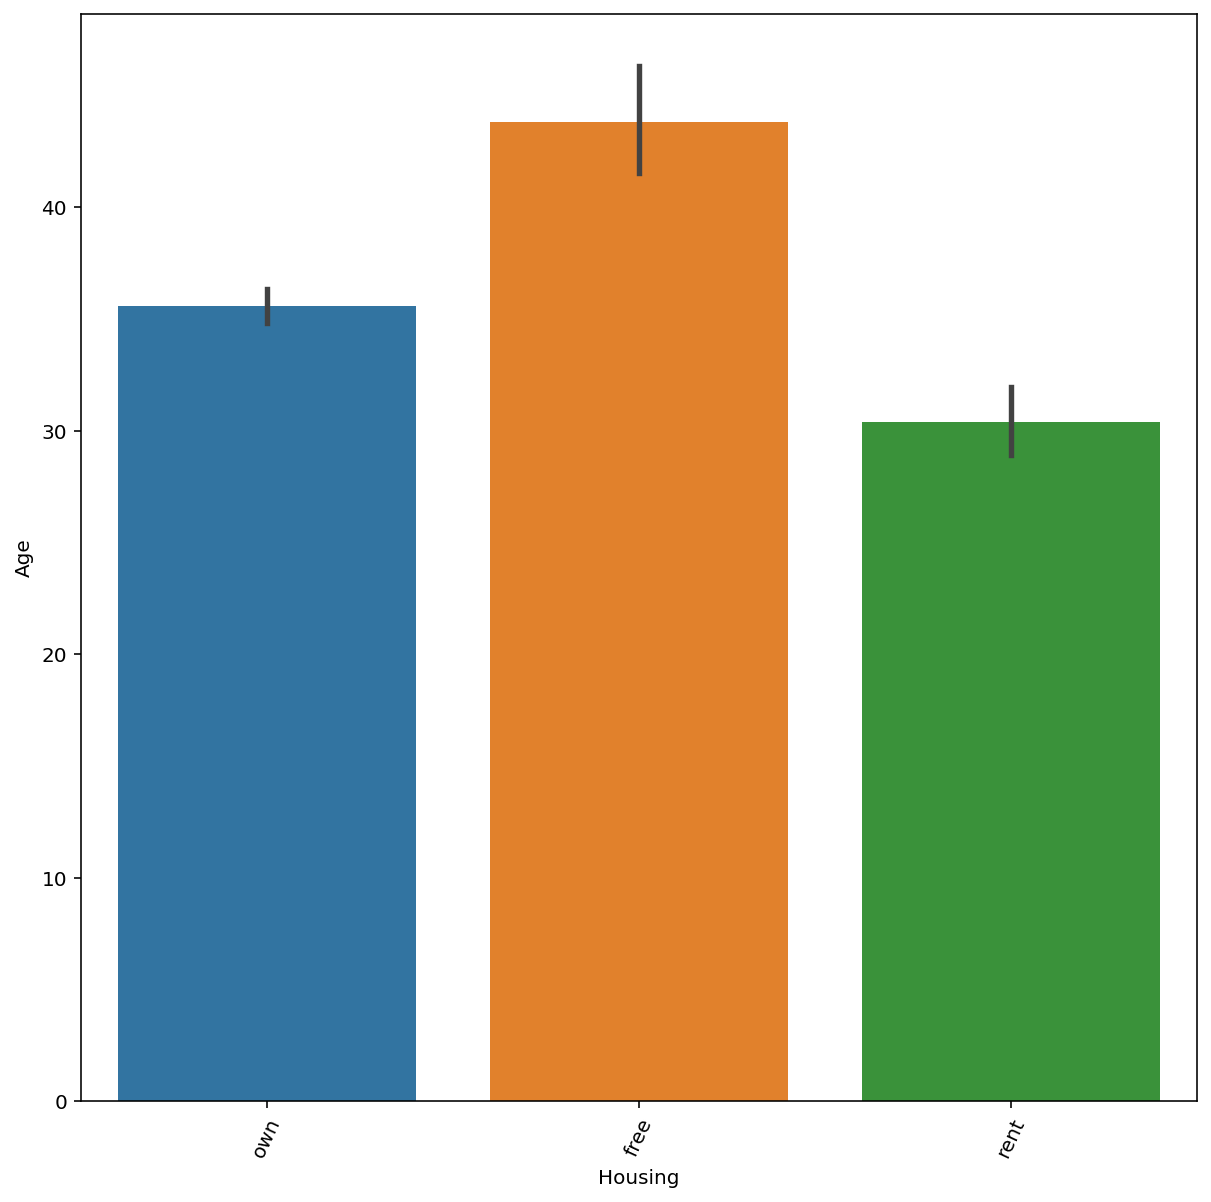

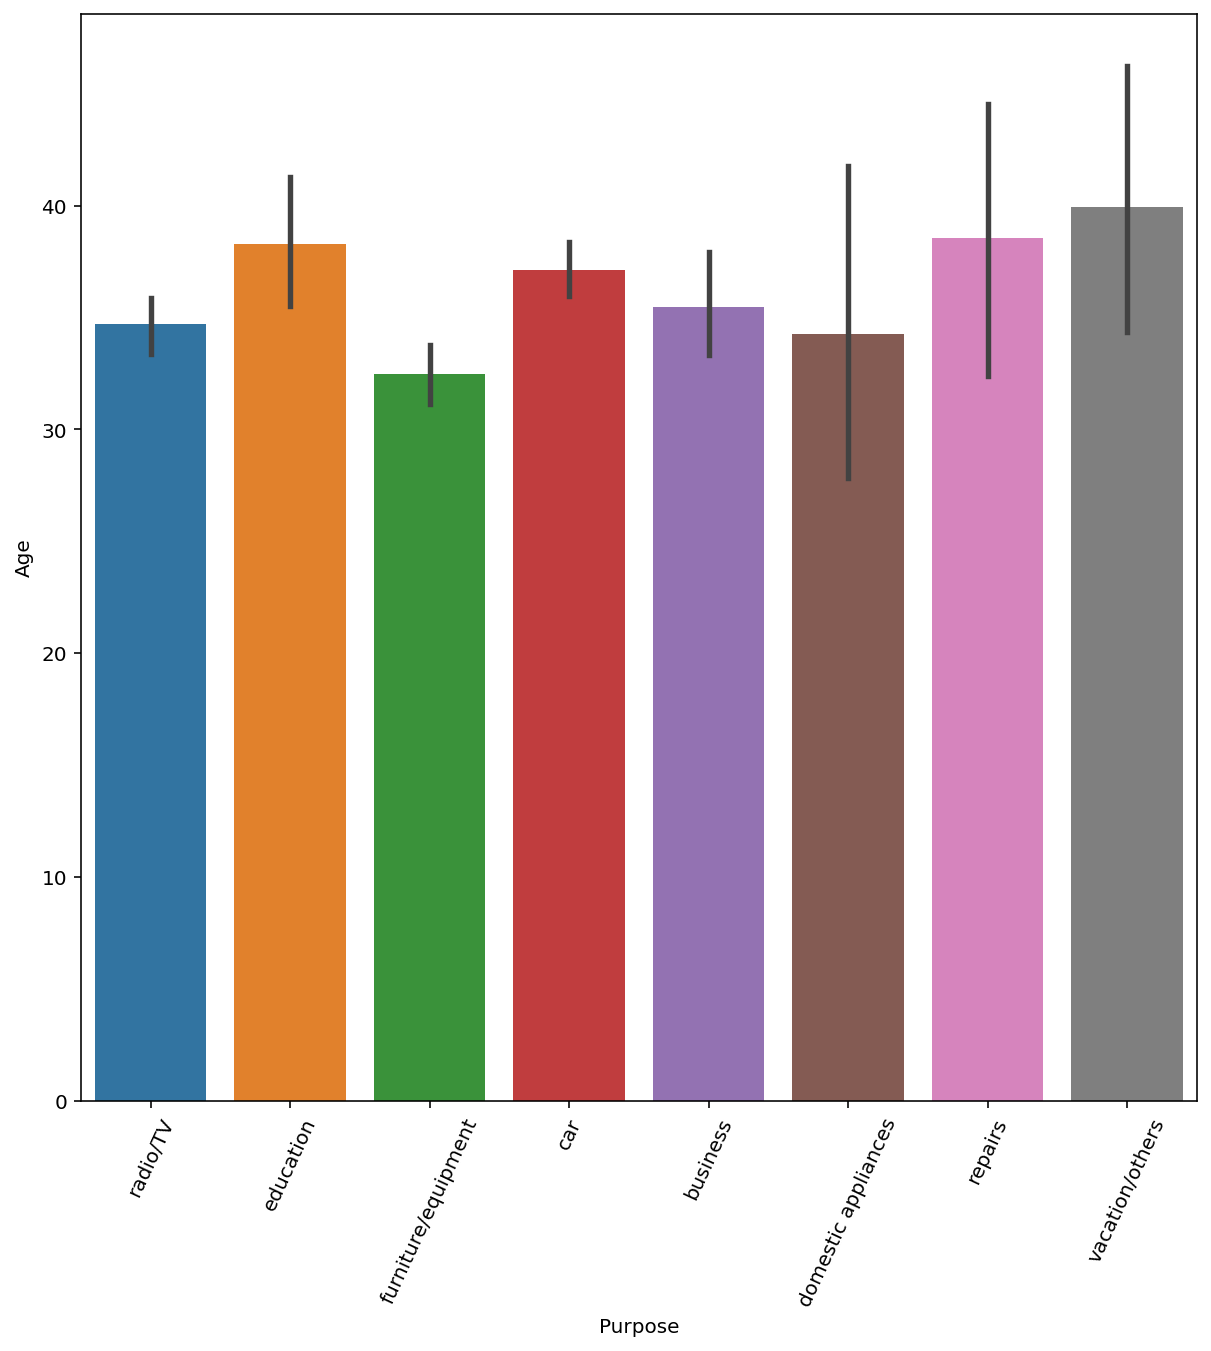

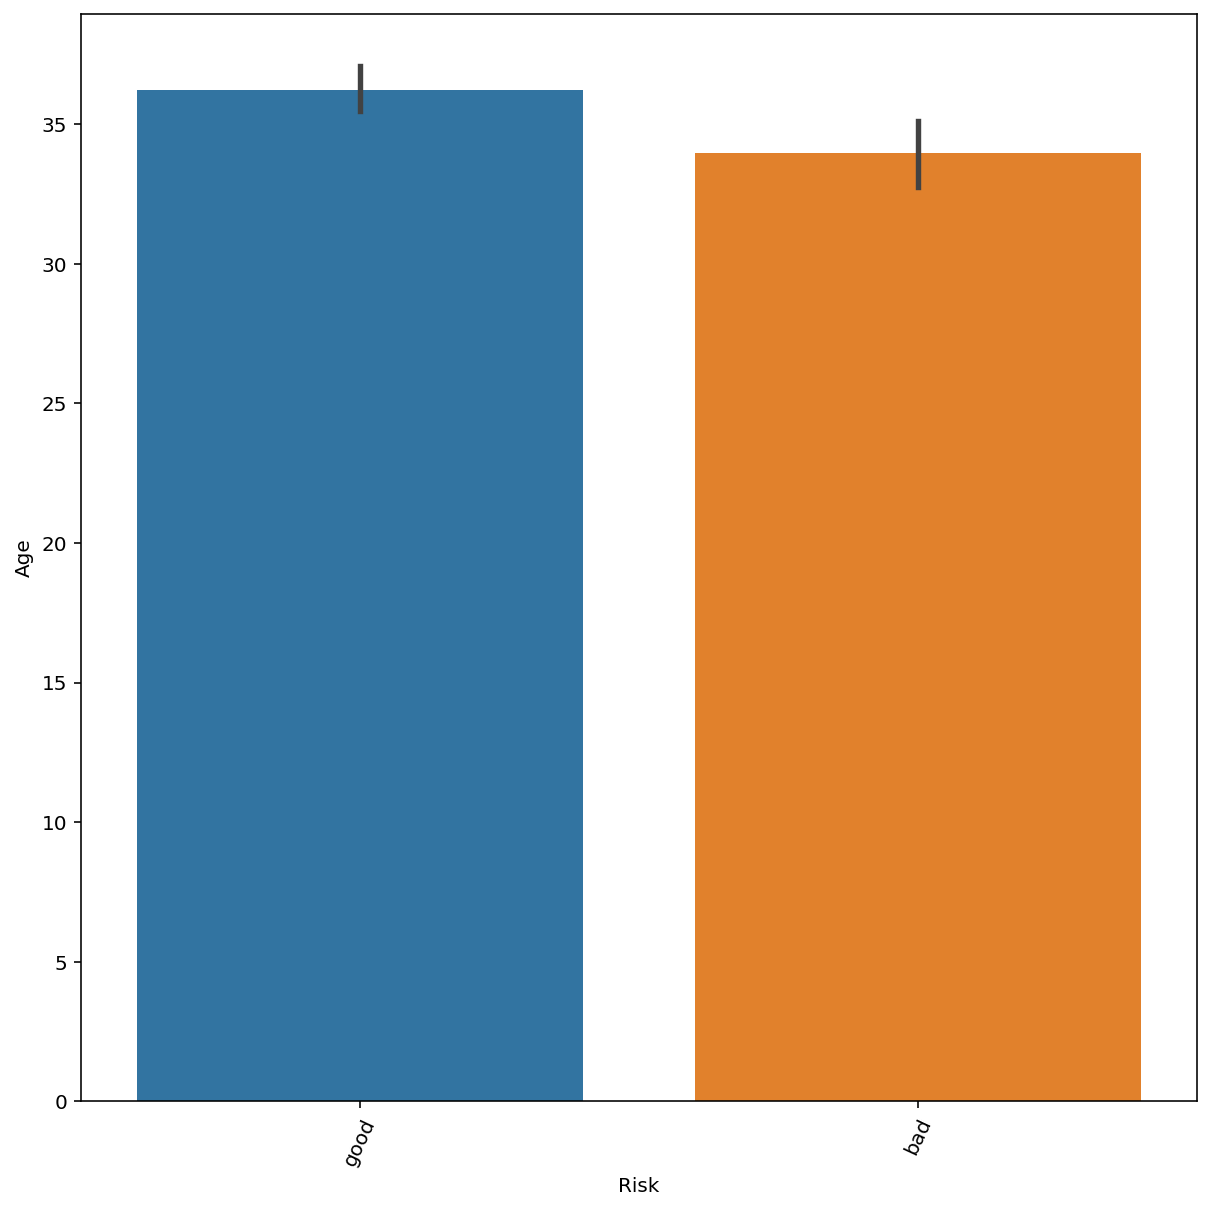

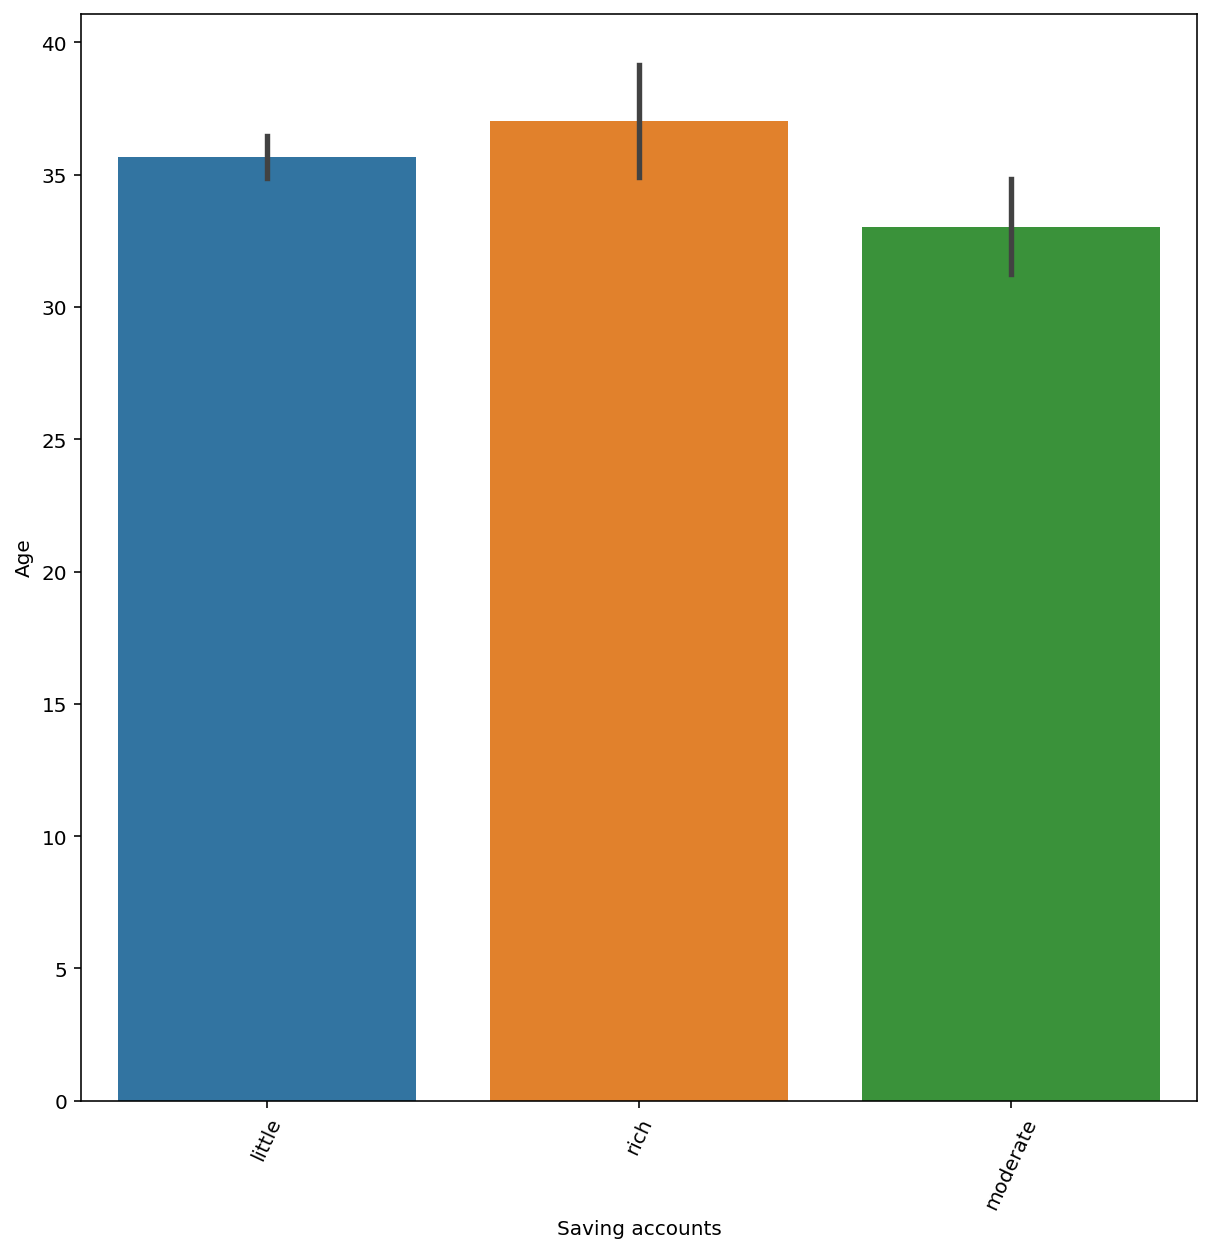

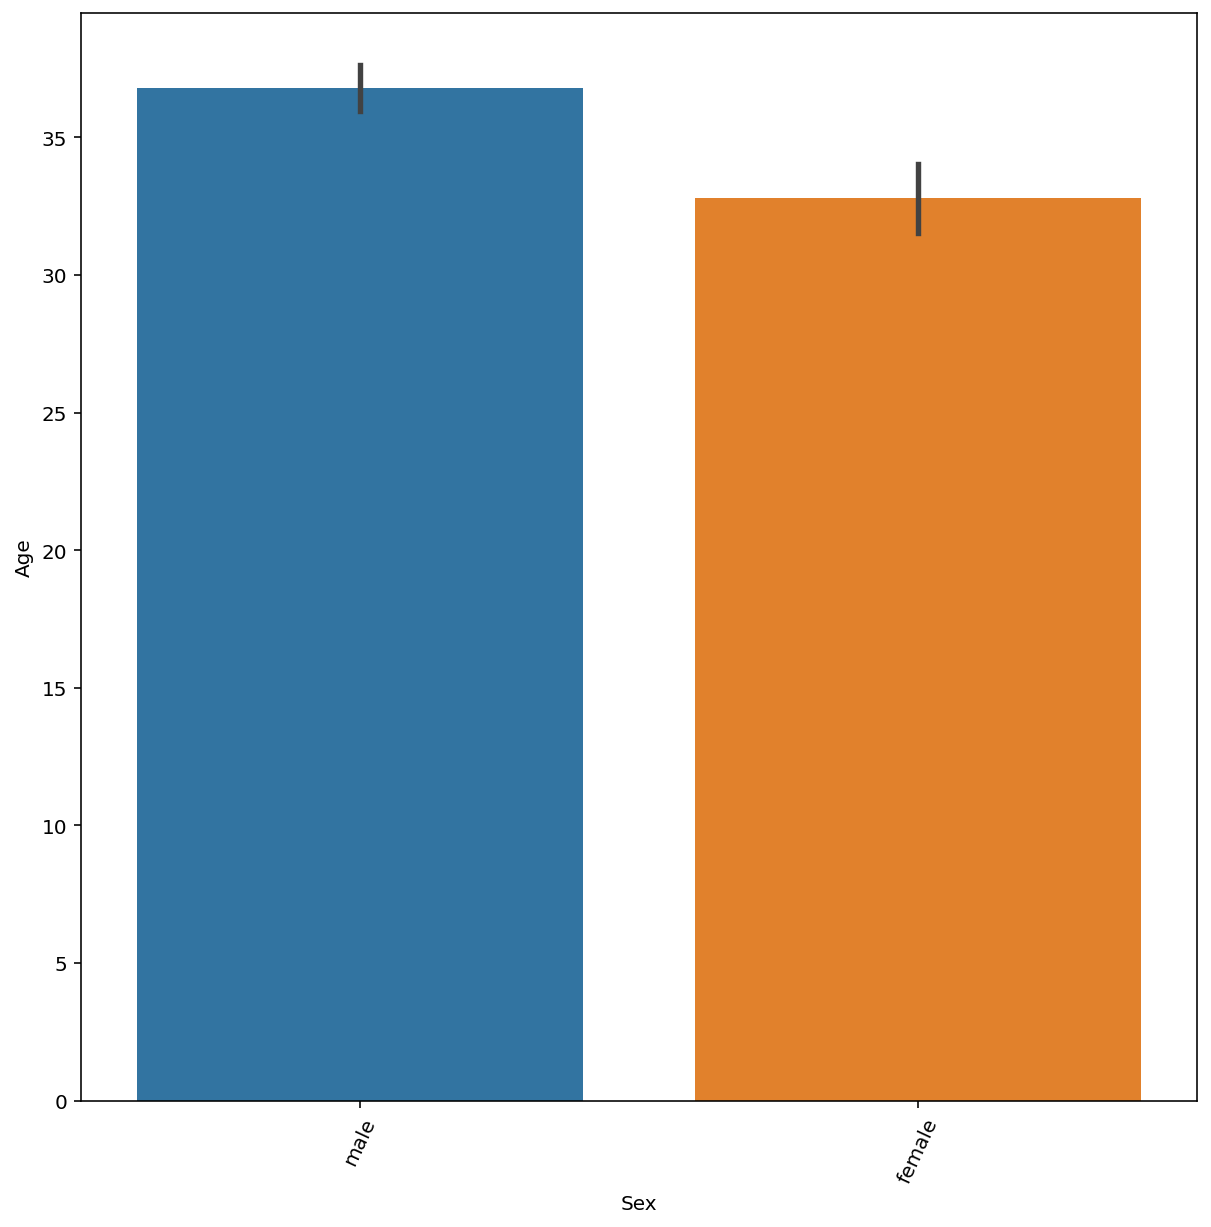

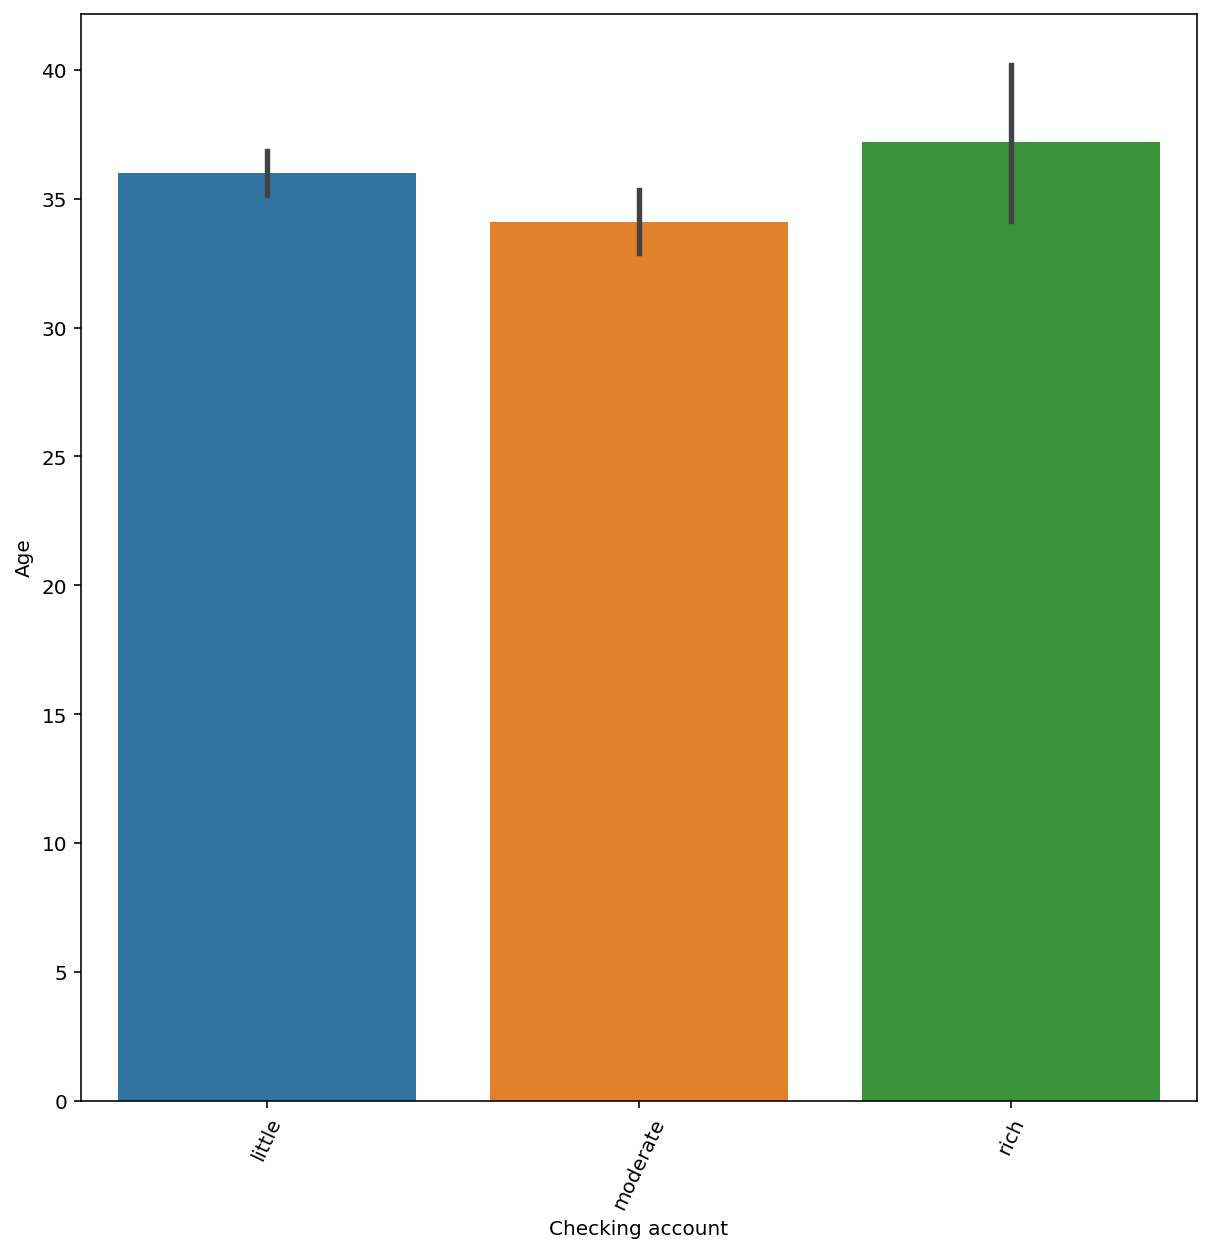

In [14]:
#Kategorik degiskenlerin, Age degiskenine gore  gorsellestirilmesi
for i in cat:
    fig, ax = plt.subplots(figsize=(10,10)) 
    sns.barplot(x= i, y="Age", data=df)
    plt.xticks( rotation = '65')
    plt.show()

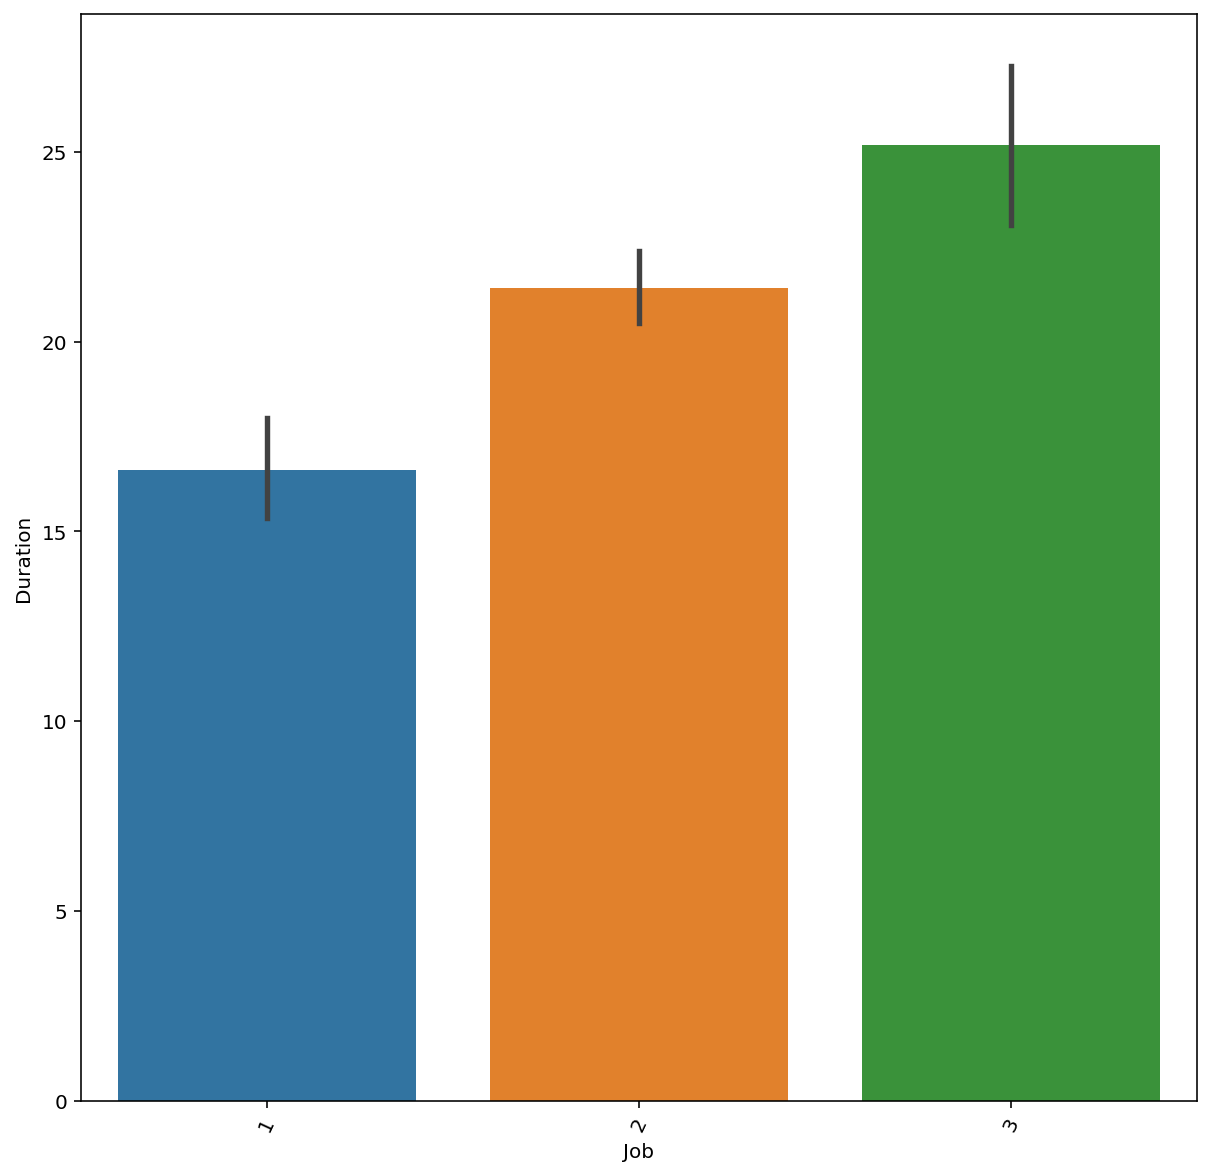

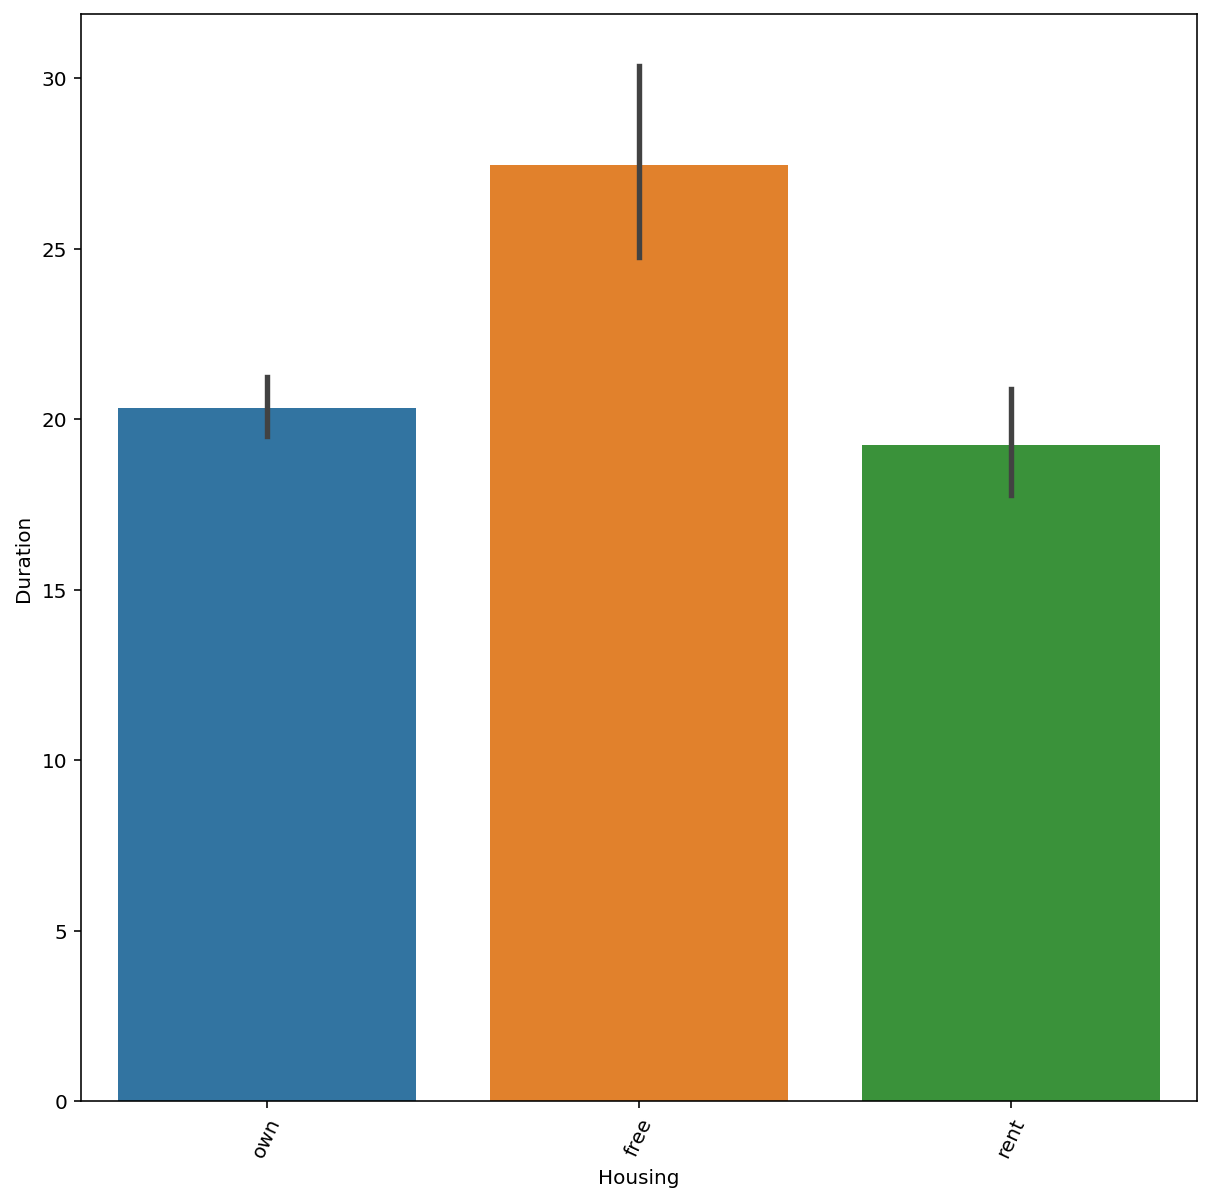

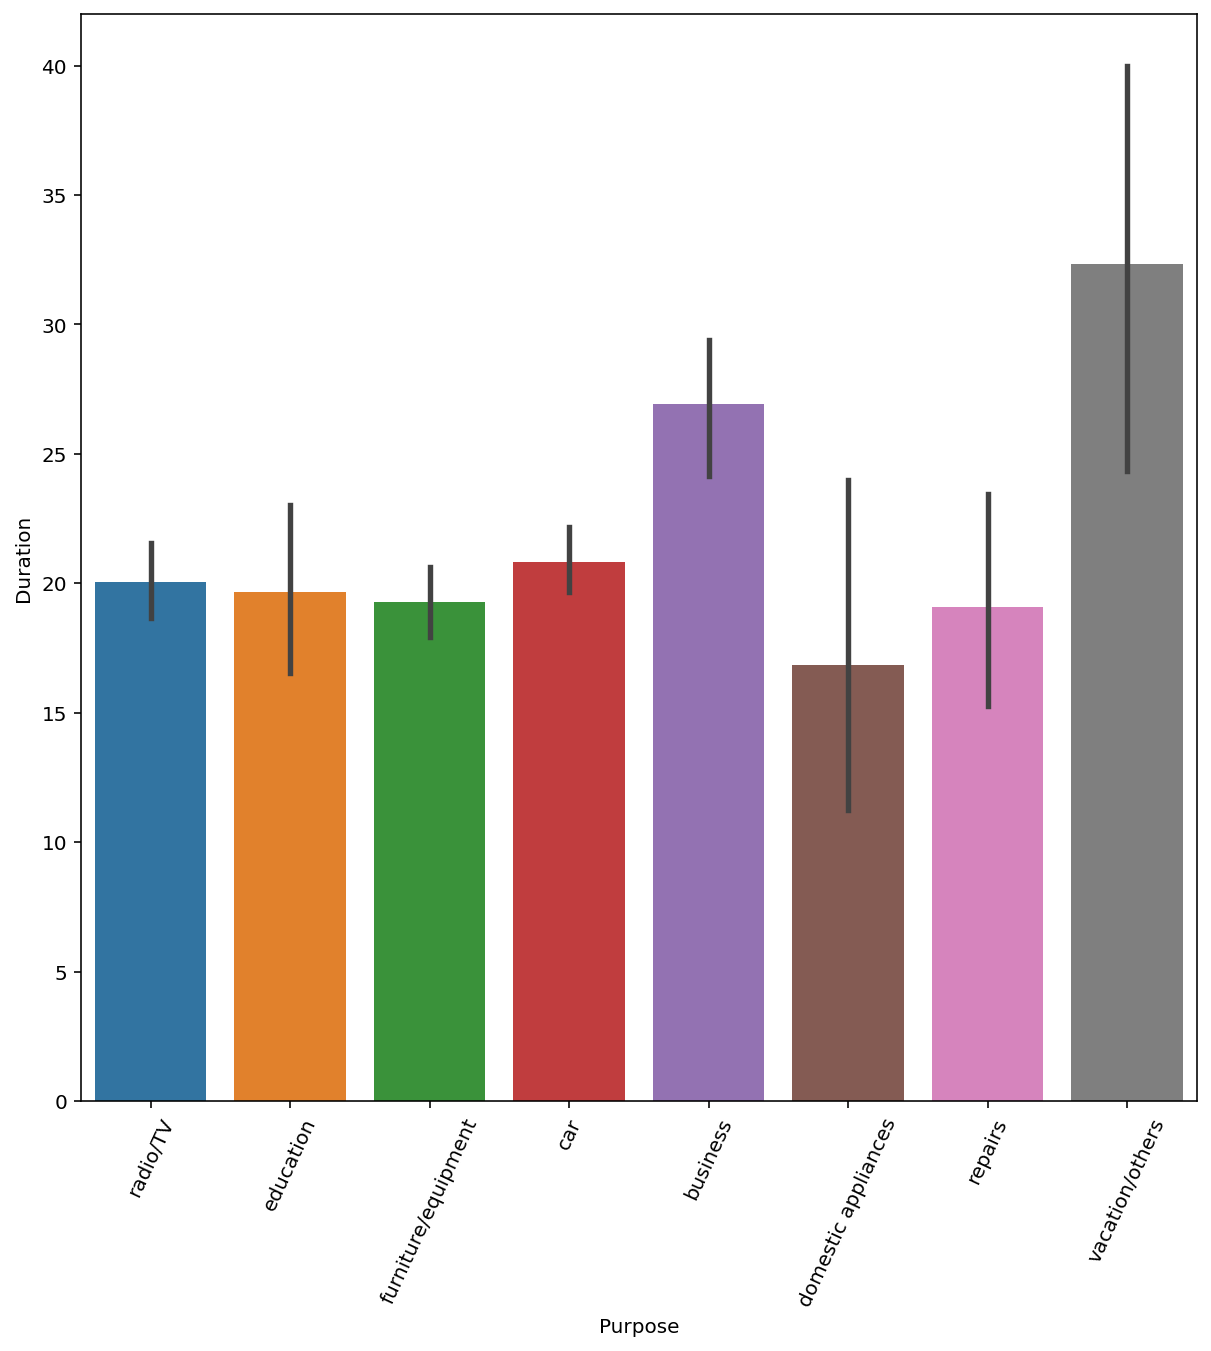

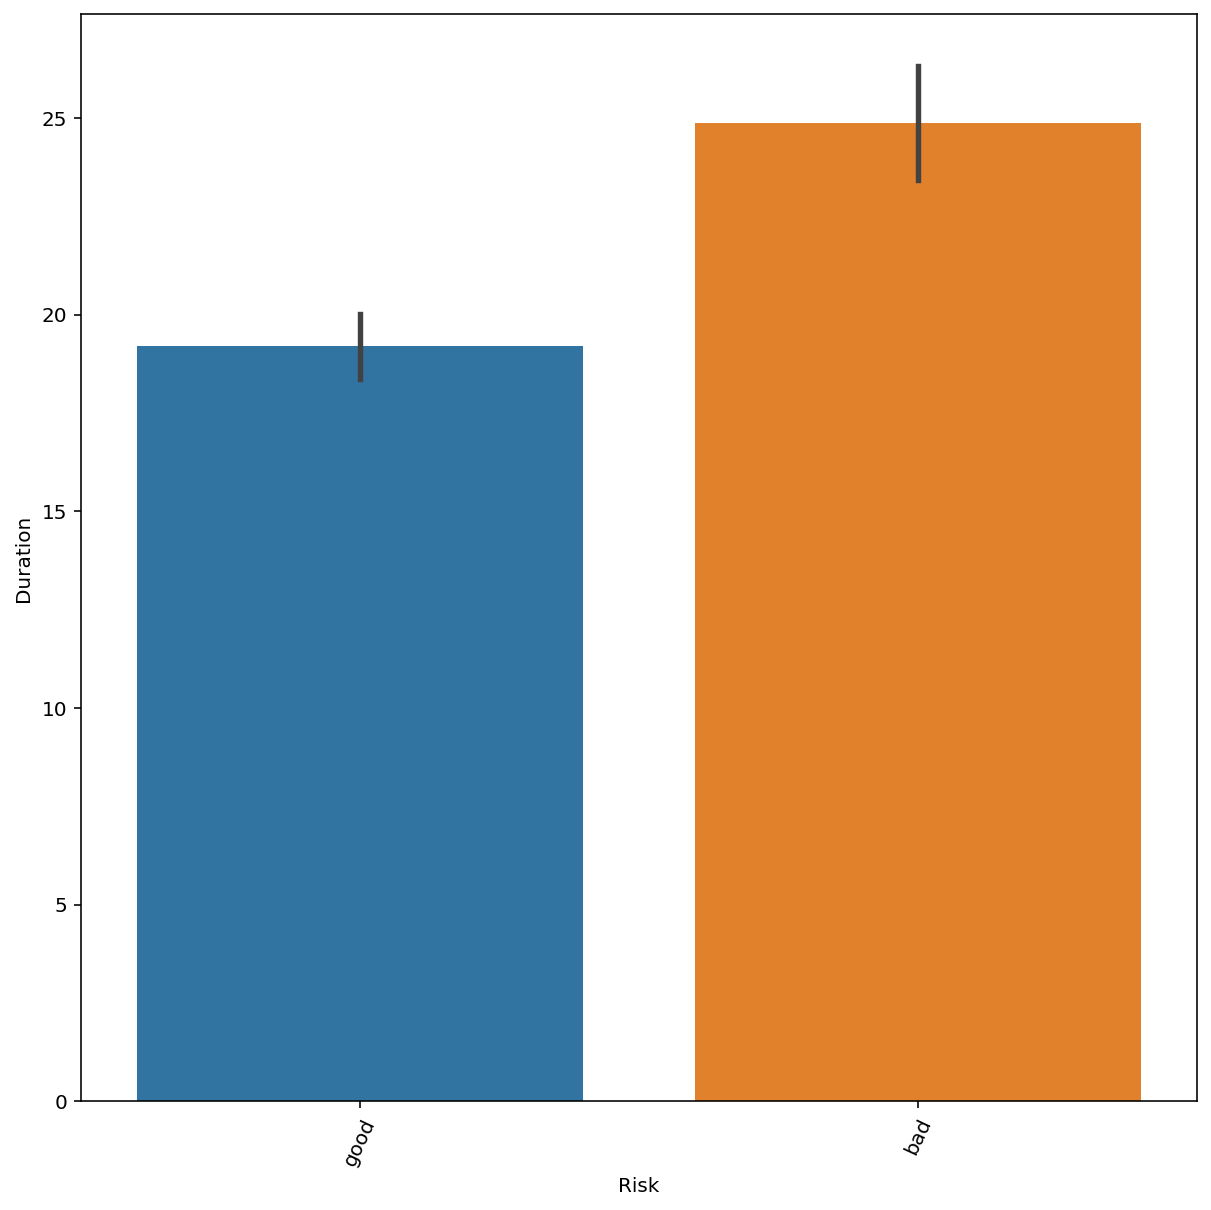

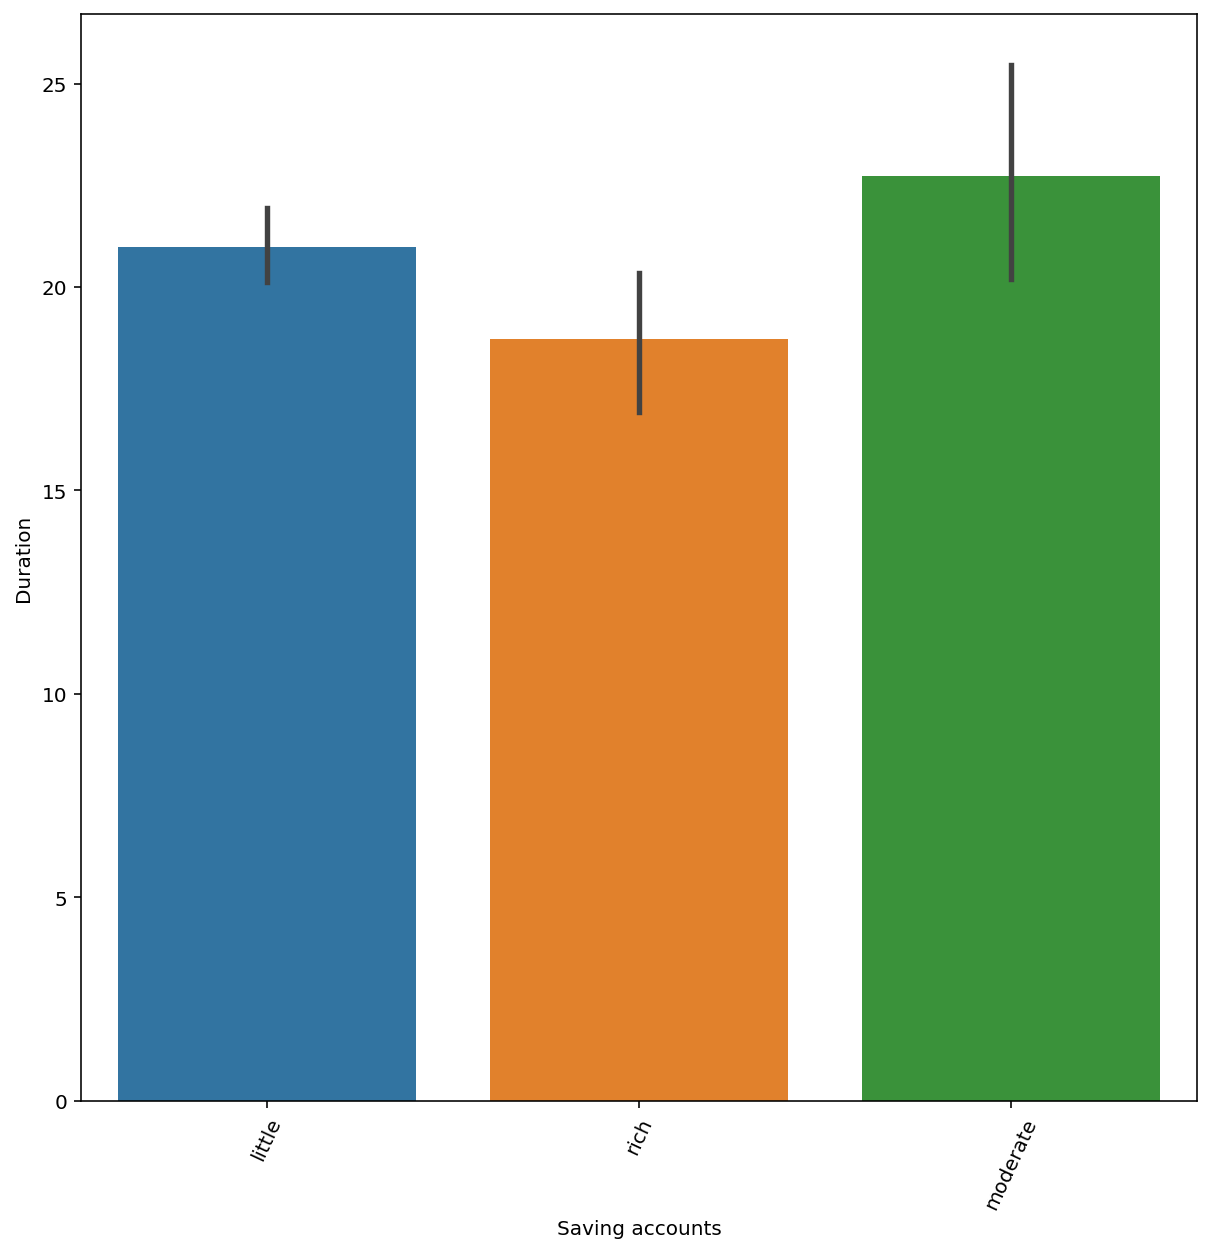

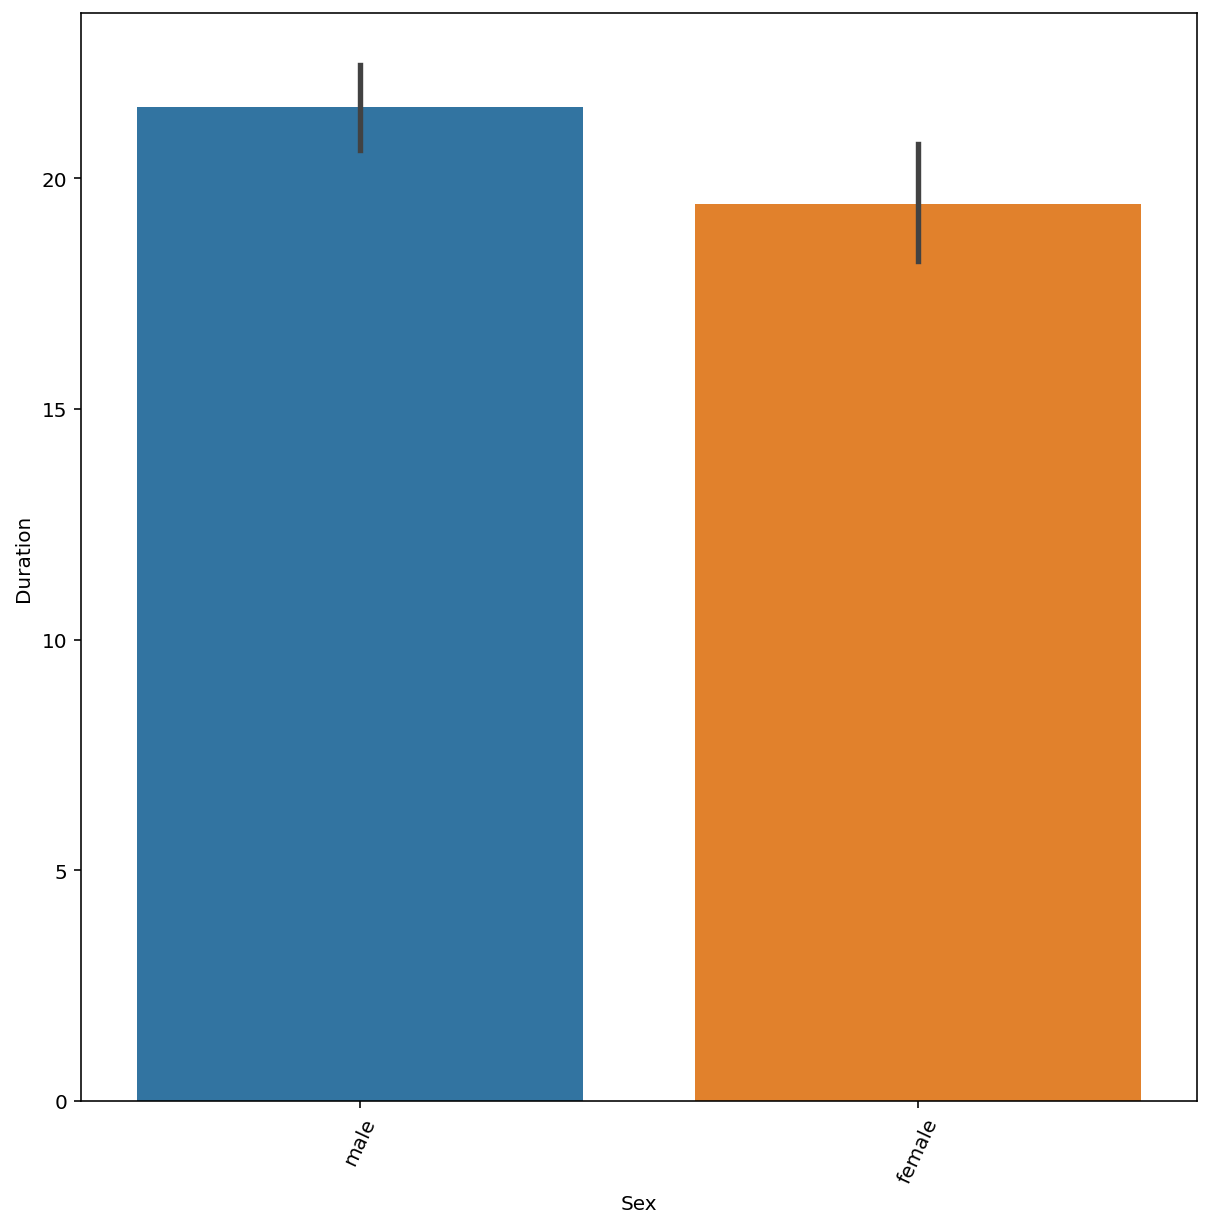

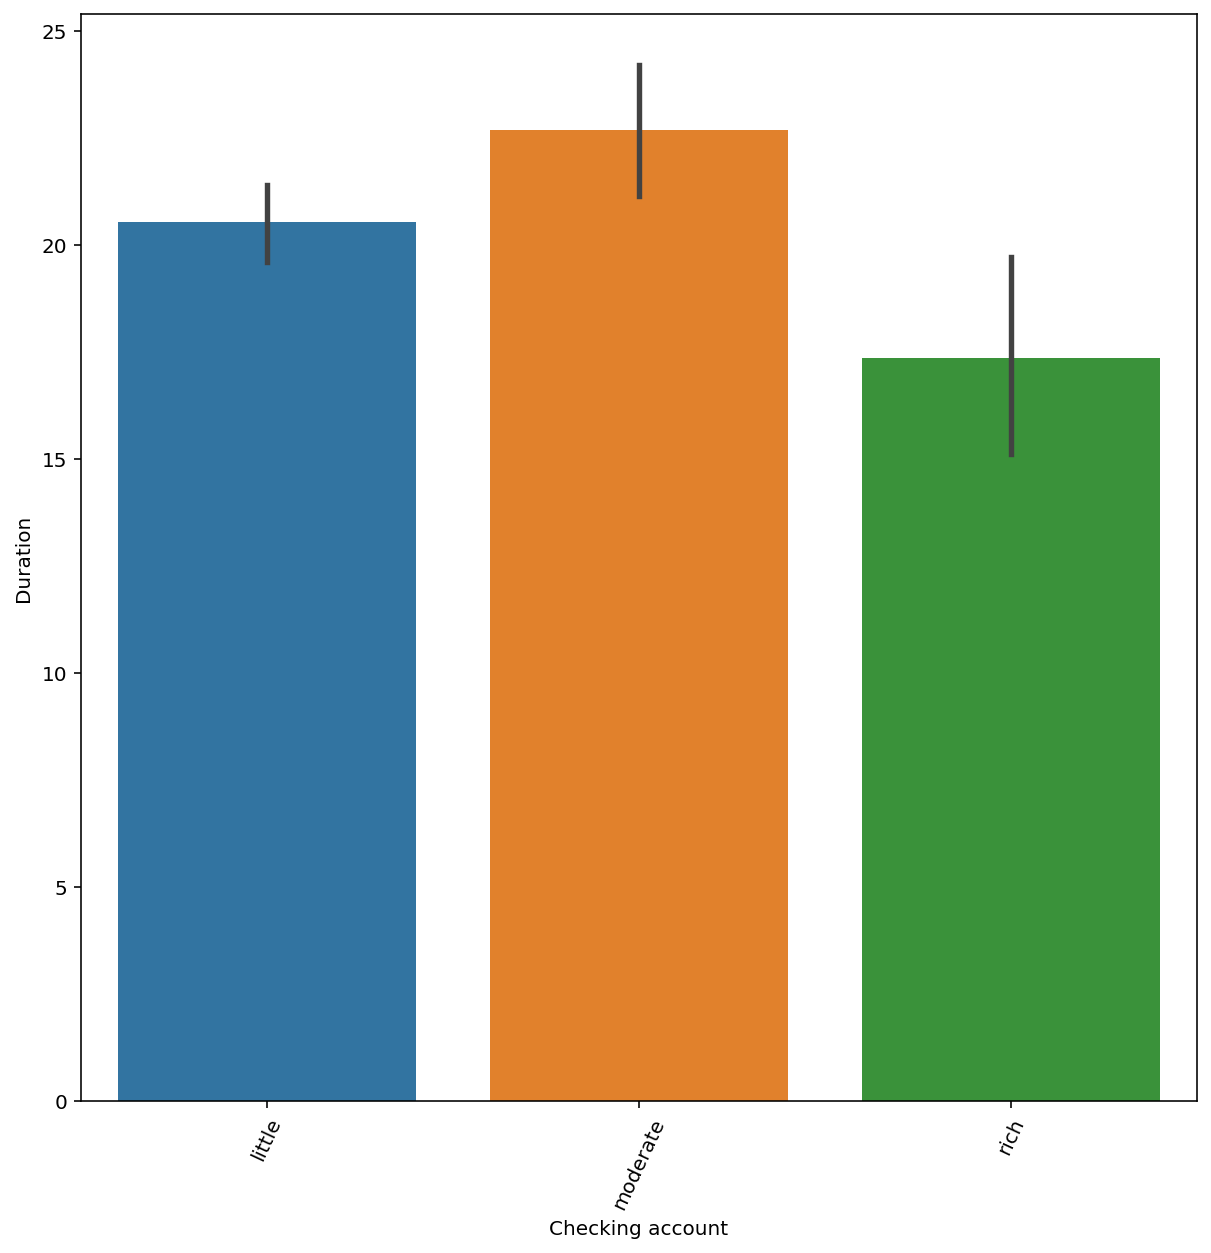

In [15]:
#Kategorik degiskenlerin, Duration degiskenine gore  gorsellestirilmesi
for i in cat:
    fig, ax = plt.subplots(figsize=(10,10))
    sns.barplot(x= i, y="Duration", data=df)
    plt.xticks( rotation = '65')
    plt.show()

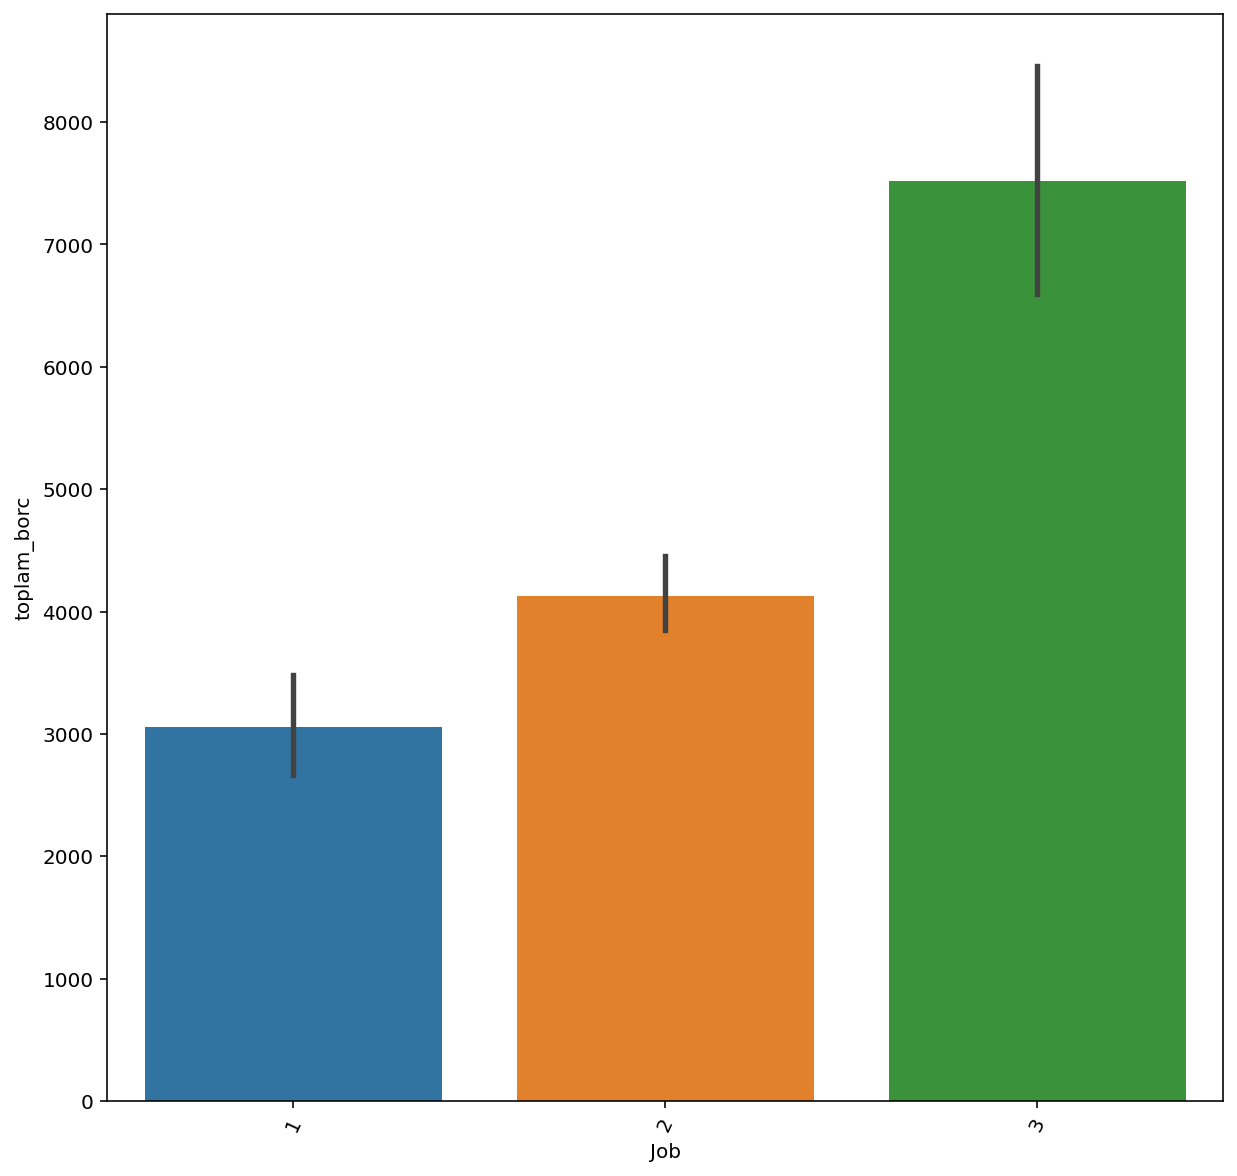

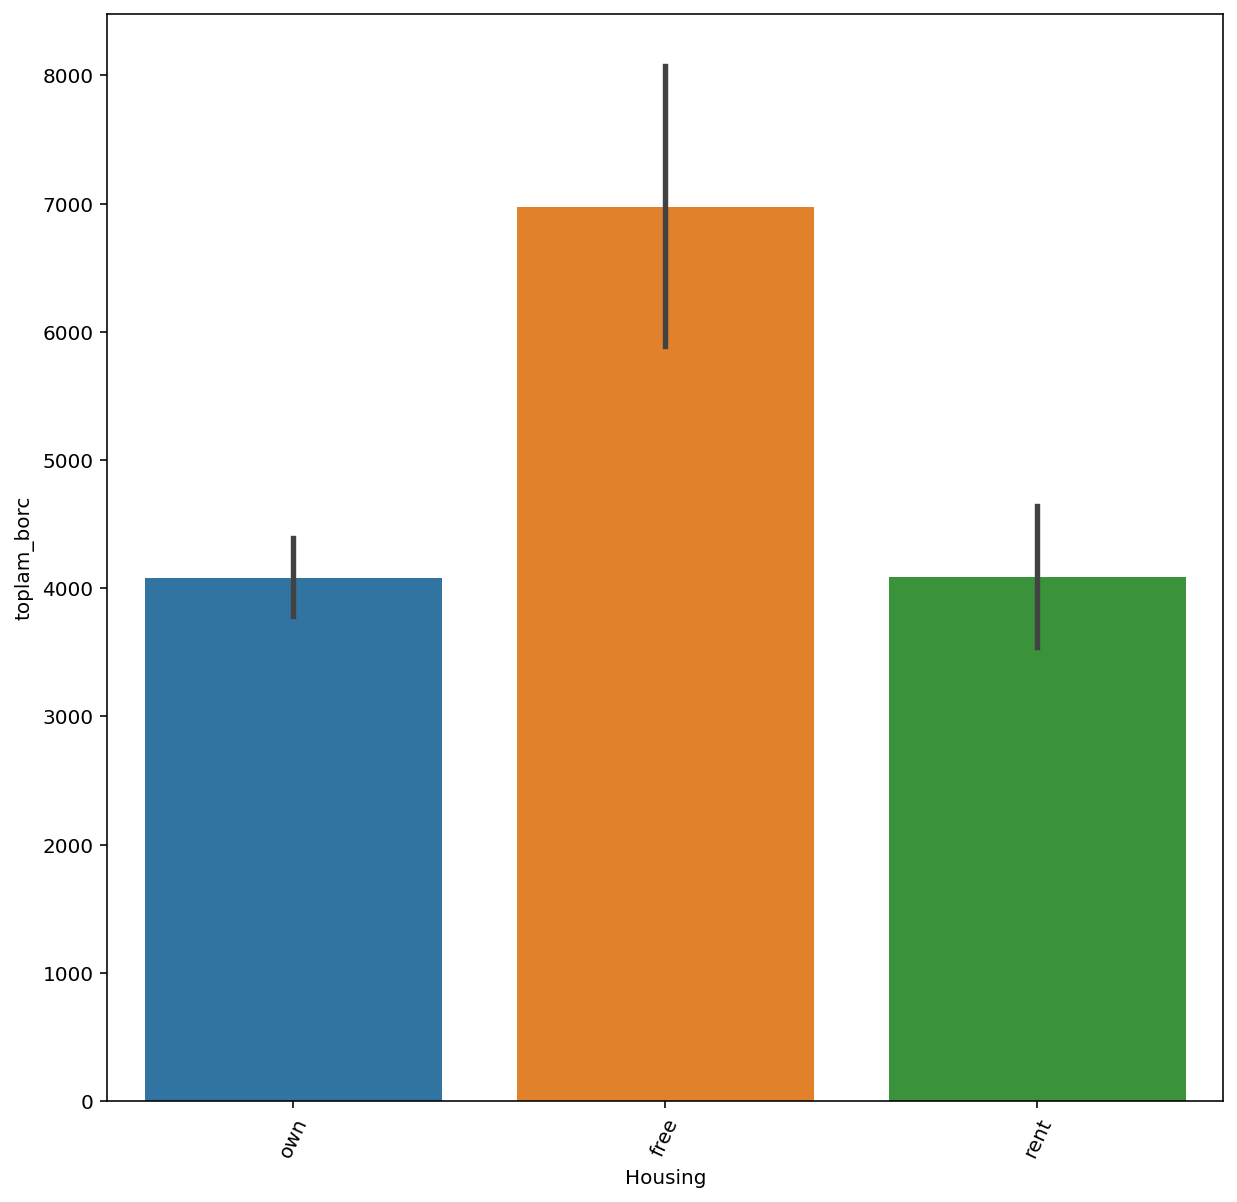

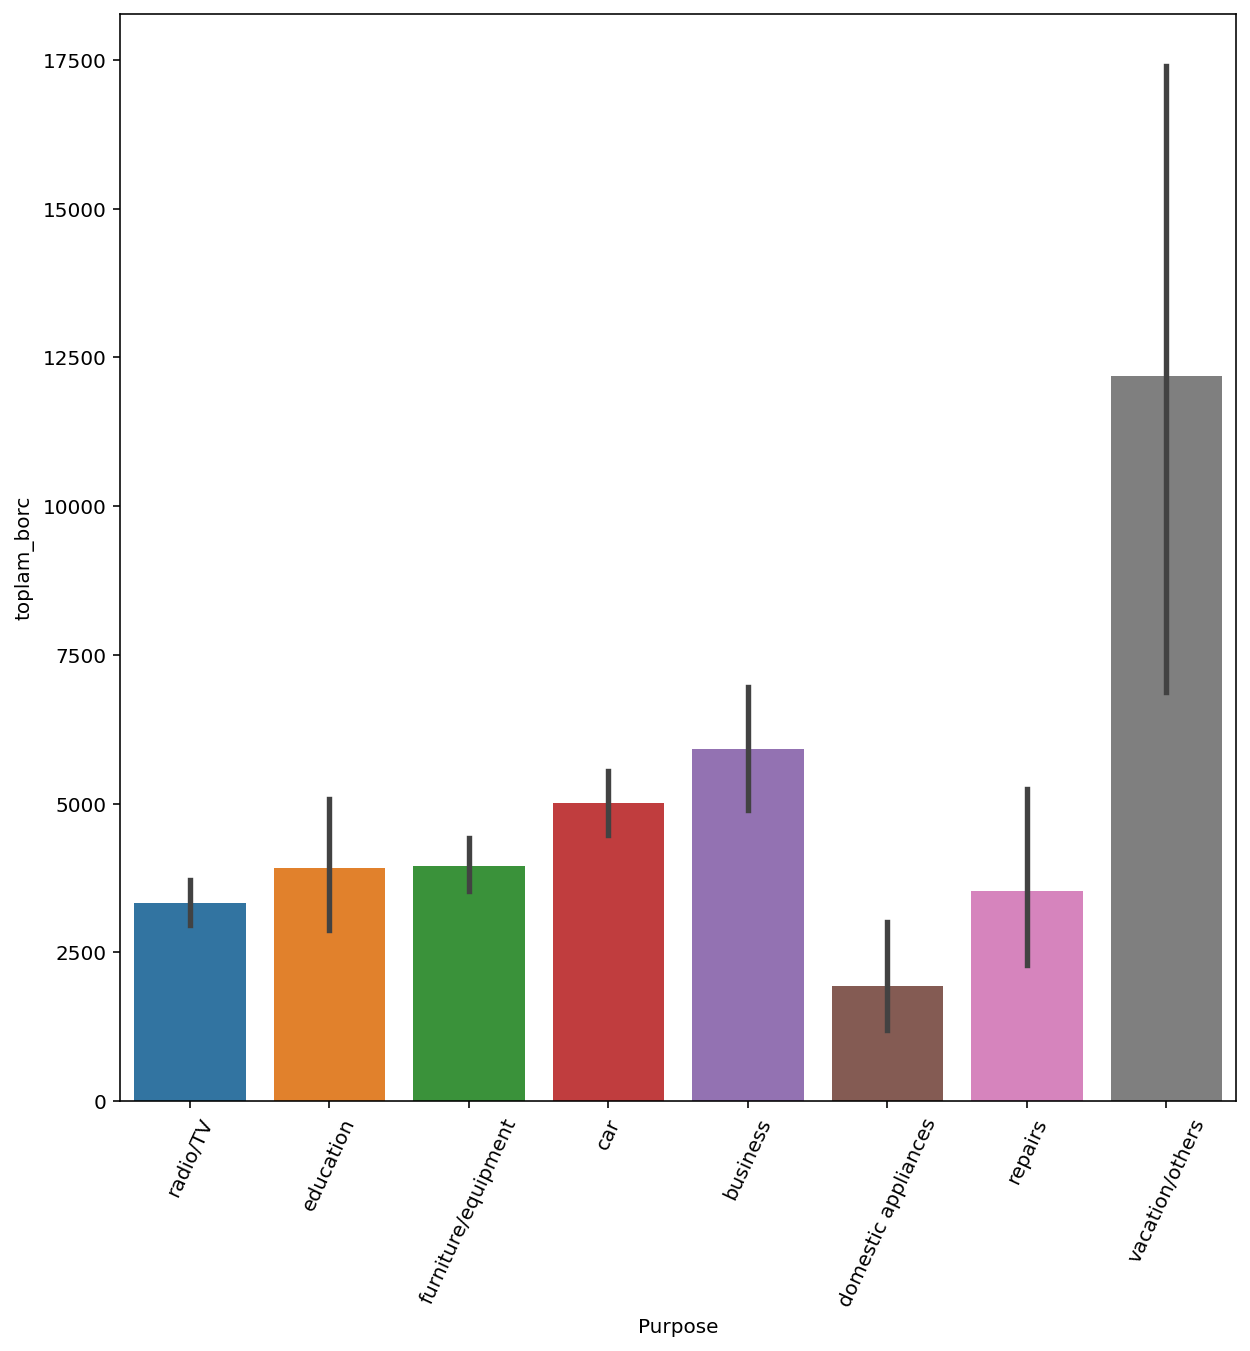

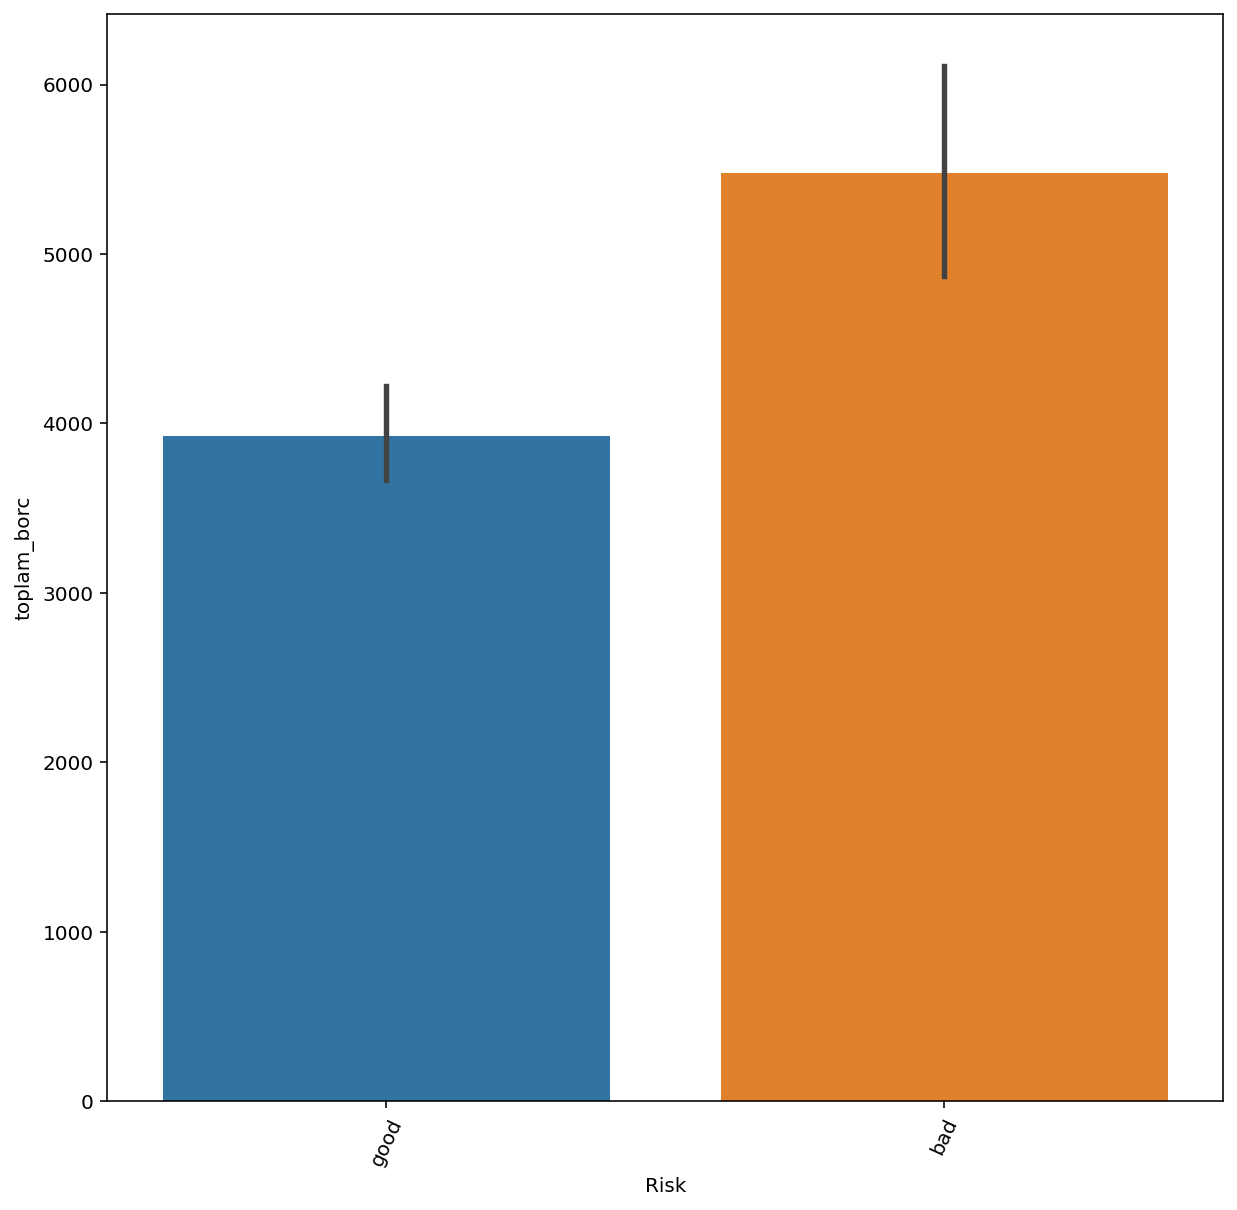

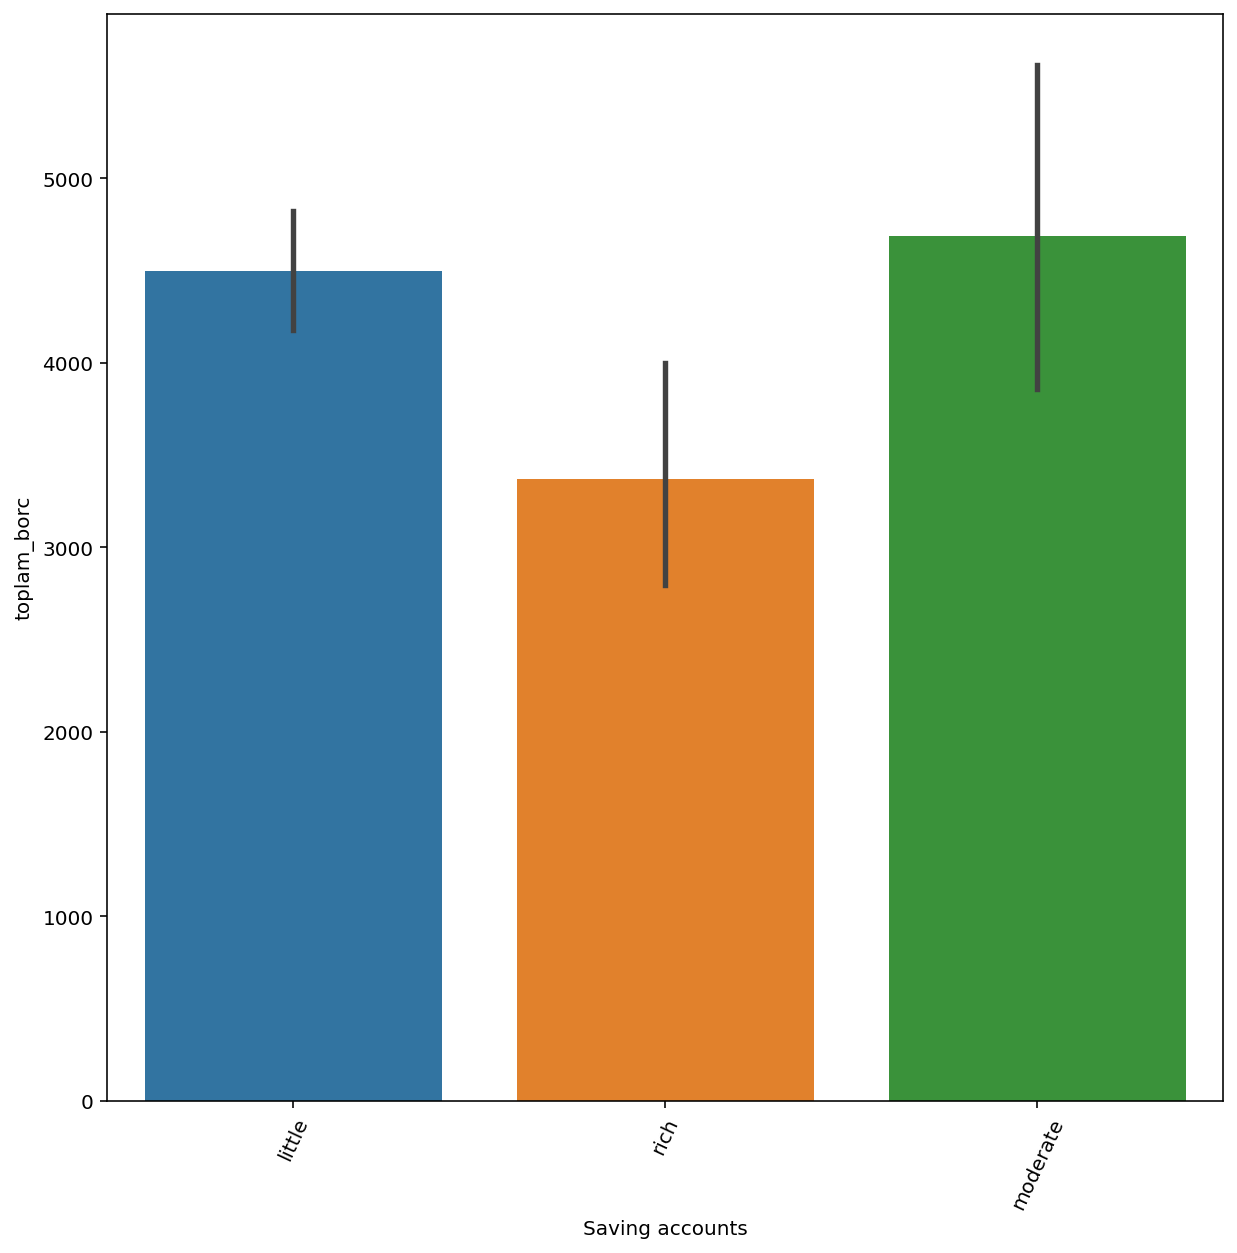

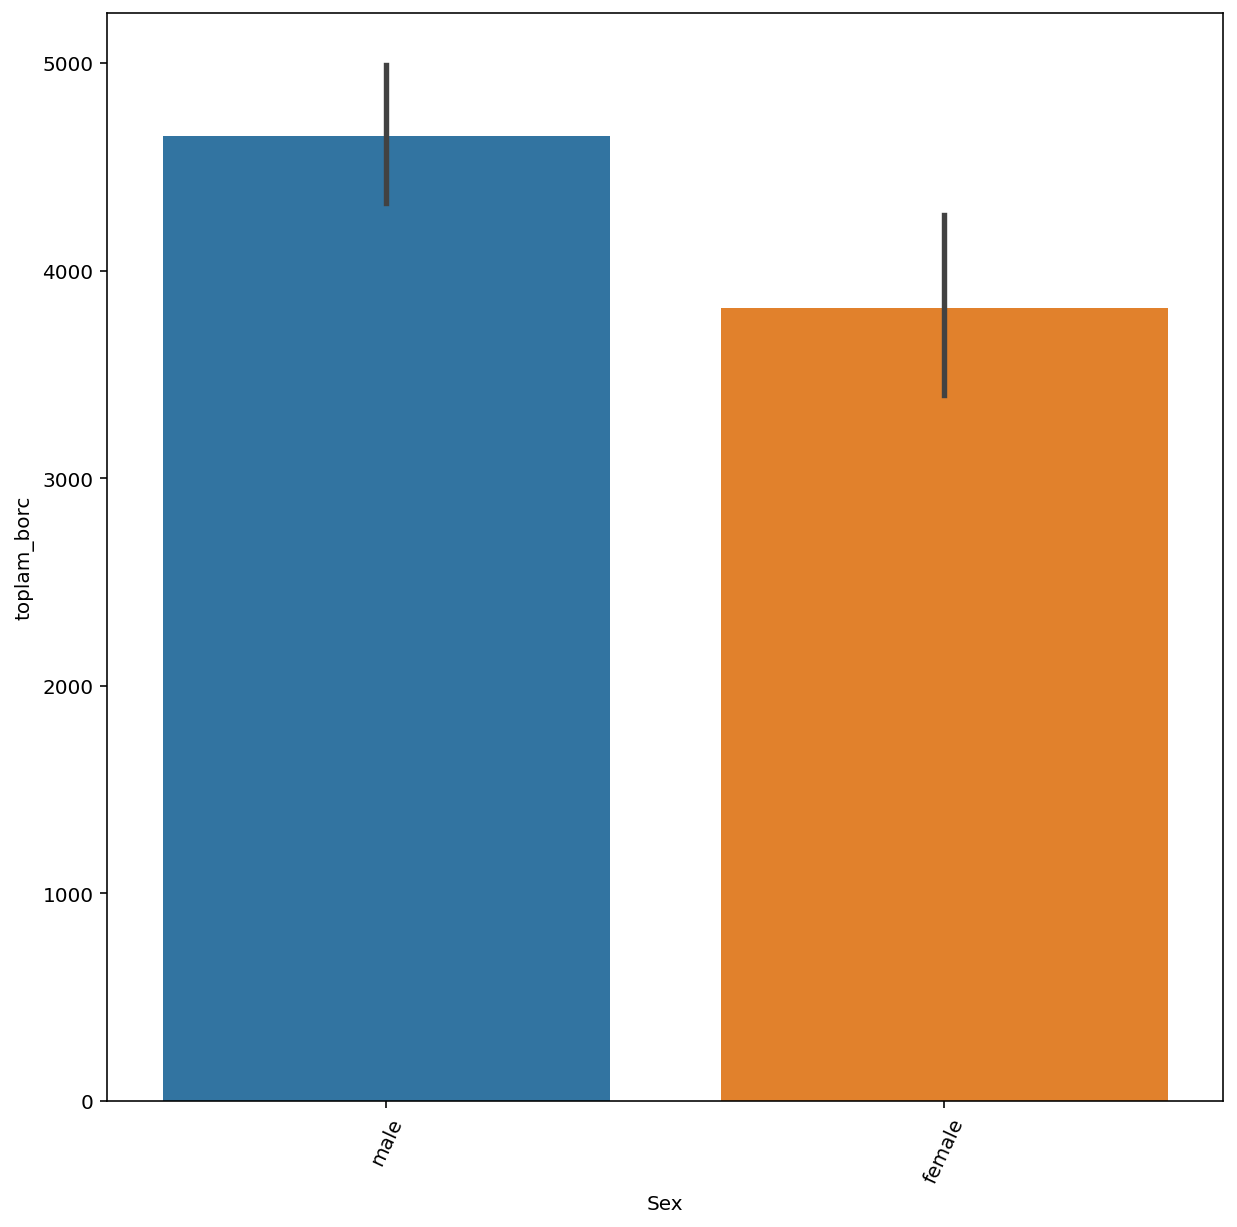

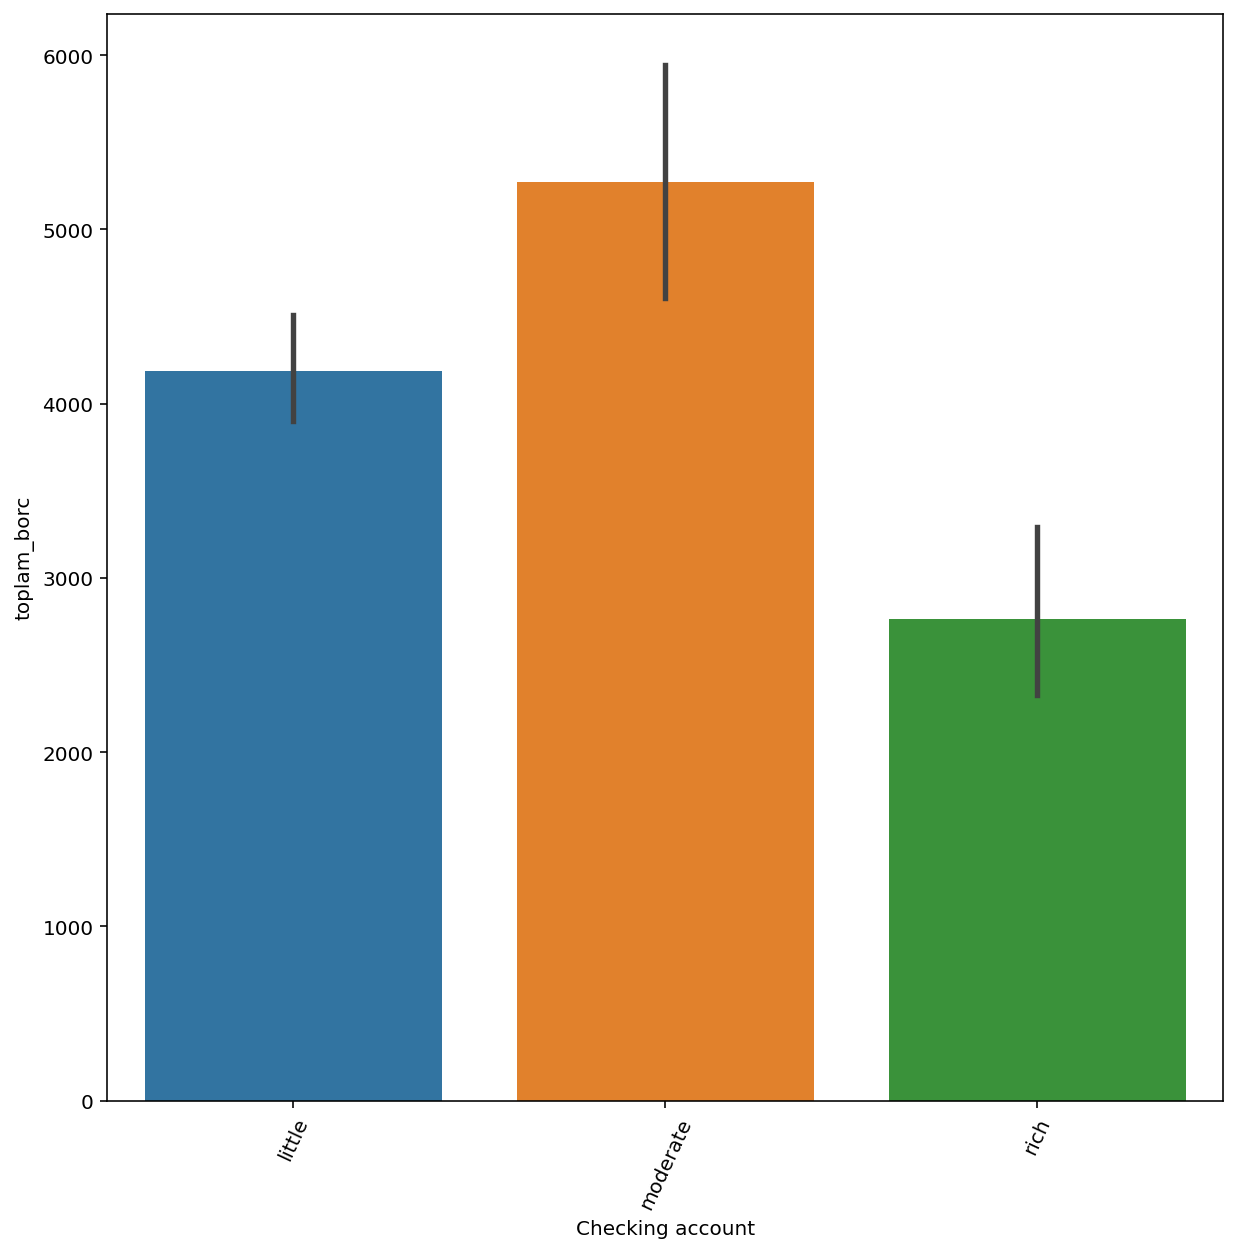

In [16]:
#Kategorik degiskenlerin, toplam_borc degiskenine gore  gorsellestirilmesi
for i in cat:
    fig, ax = plt.subplots(figsize=(10,10)) 
    sns.barplot(x= i, y="toplam_borc", data=df)
    plt.xticks( rotation = '65')
    plt.show()

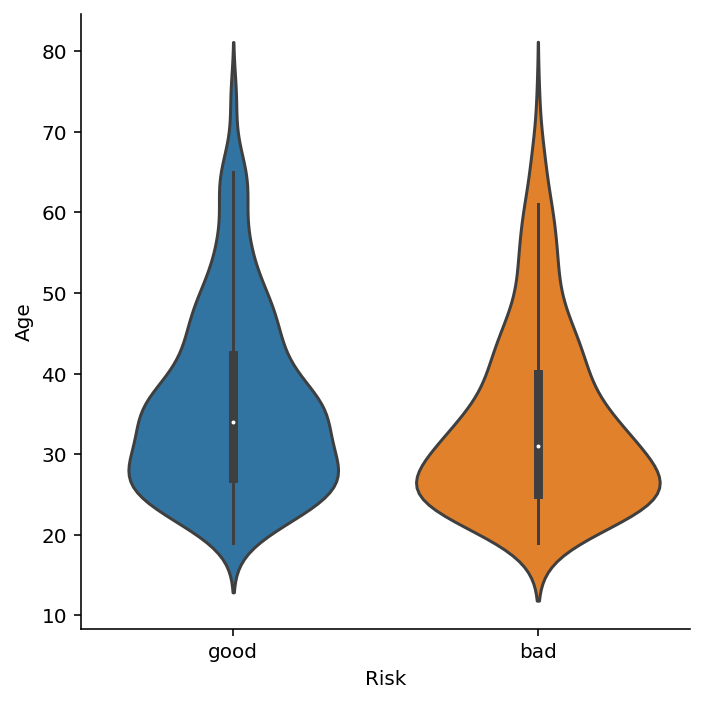

In [17]:
#Age degiskeninin Risk bazında degerlendirilmesi
sns.catplot(x ="Risk" , y="Age" ,data = df , kind="violin")
plt.show()

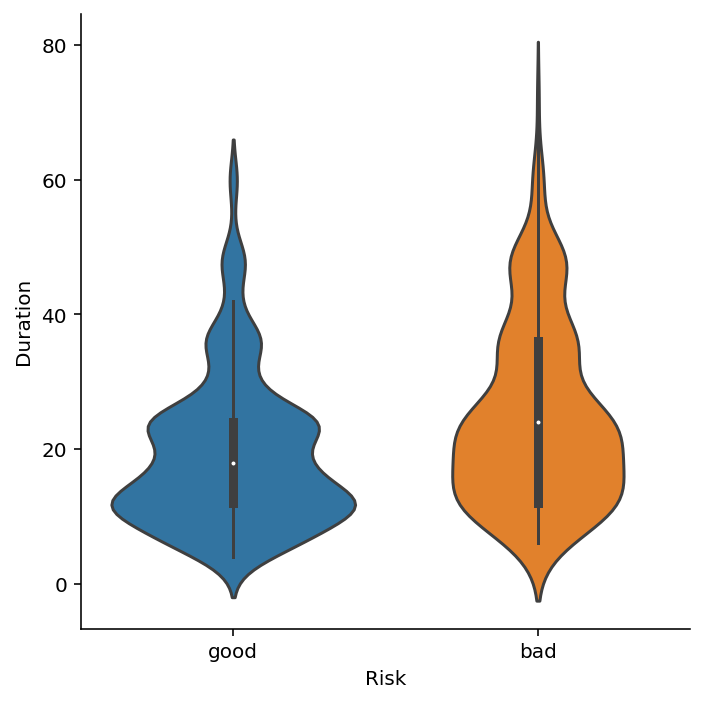

In [18]:
#Duration degiskeninin Risk bazında degerlendirilmesi
sns.catplot(x ="Risk" , y="Duration" ,data = df , kind="violin")
plt.show()

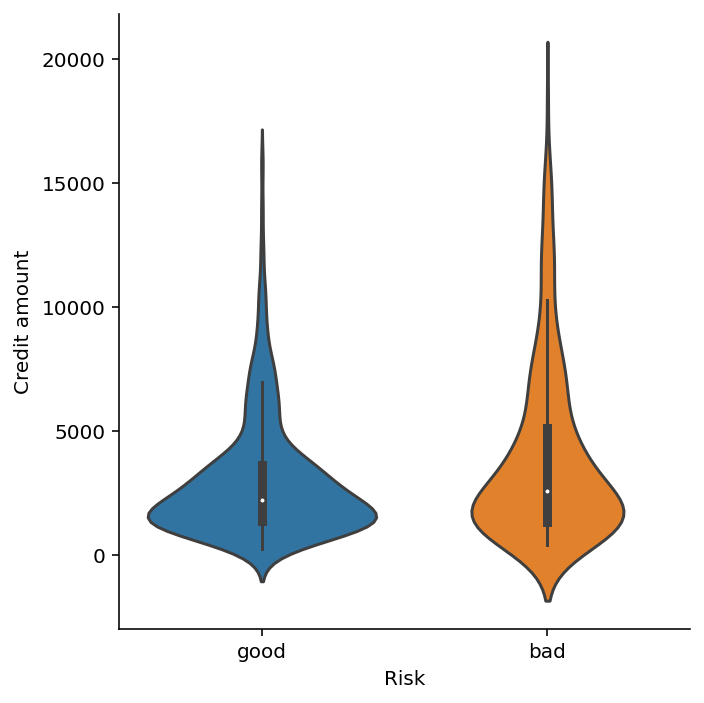

In [19]:
#Credit amount degiskeninin Risk bazında degerlendirilmesi
sns.catplot(x ="Risk" , y="Credit amount" ,data = df , kind="violin")
plt.show()

In [20]:
#Baskılama islemi
df.loc[df["Credit amount"] > 10000 ,"Credit amount"] = 10000
#df.loc[(df["Duration"] > 55) & (df.Risk == "good") ,"Duration"] = 55

In [21]:
#eksik degerlerin sorgulanması
df.isnull().sum()

Age                 0
Sex                 0
Job                 0
Housing             0
Saving accounts     0
Checking account    0
Credit amount       0
Duration            0
Purpose             0
Risk                0
faiz_yuzdesi        0
toplam_borc         0
faiz_tutari         0
yas_sure            0
ust_yas             0
c_d                 0
d_a                 0
dtype: int64

In [22]:
# Kac kategorik değişken var ve isimleri neler?
cat_cols = [col for col in df.columns if df[col].dtypes == 'O' and len(df[col].unique()) < 10]
print('Kategorik Değişken Sayısı: ', len(cat_cols))
print(cat_cols)

more_cat_cols = [col for col in df.columns if len(df[col].unique()) < 10]
print('Kategorik Değişken Sayısı: ', len(more_cat_cols))
print(more_cat_cols)

Kategorik Değişken Sayısı:  6
['Sex', 'Housing', 'Saving accounts', 'Checking account', 'Purpose', 'Risk']
Kategorik Değişken Sayısı:  7
['Sex', 'Job', 'Housing', 'Saving accounts', 'Checking account', 'Purpose', 'Risk']


In [23]:
# Hangi kategorik değişkenin kaç sınıfı var?
df[more_cat_cols].nunique()

Sex                 2
Job                 3
Housing             3
Saving accounts     3
Checking account    3
Purpose             8
Risk                2
dtype: int64

        Sex  Ratio
male    690   69.0
female  310   31.0




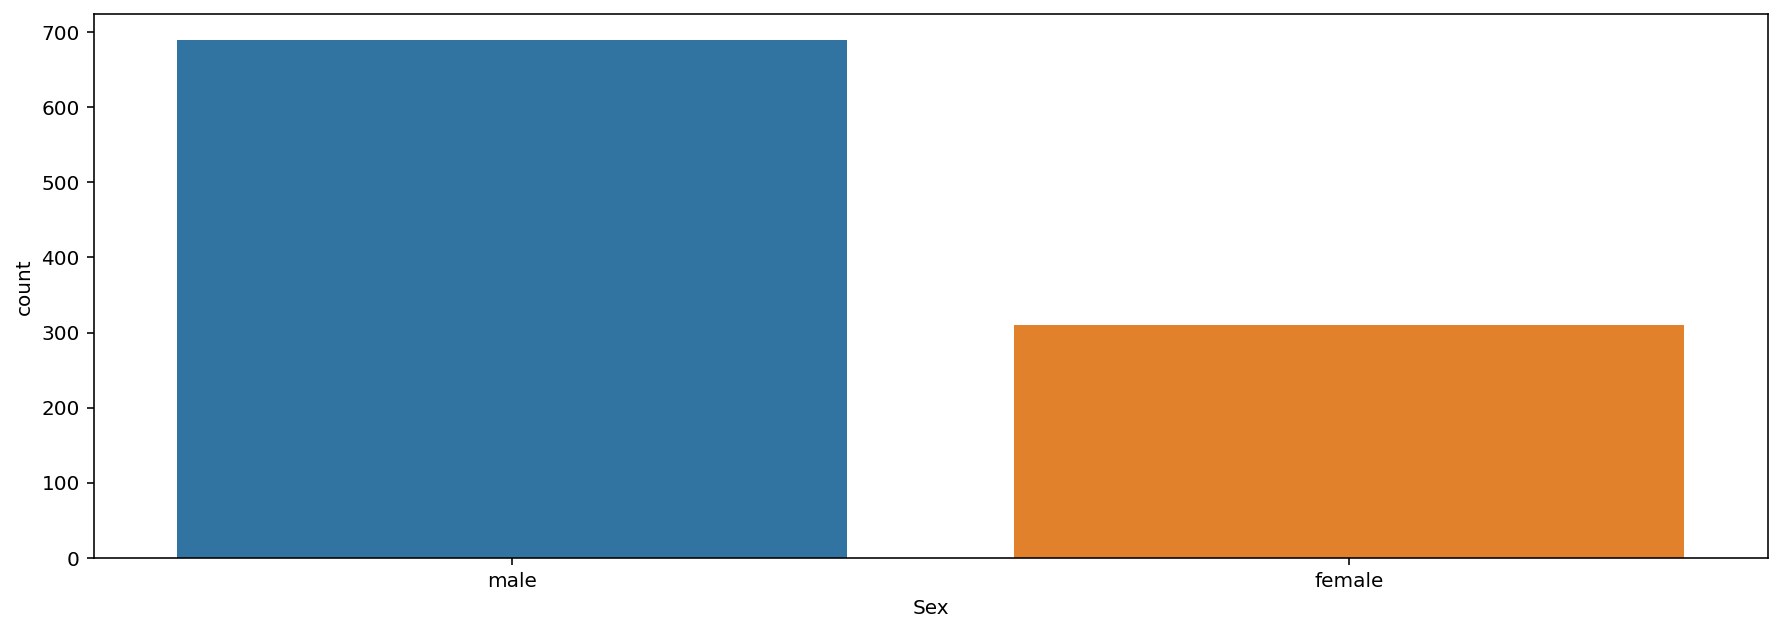

   Job  Ratio
2  630   63.0
1  222   22.2
3  148   14.8




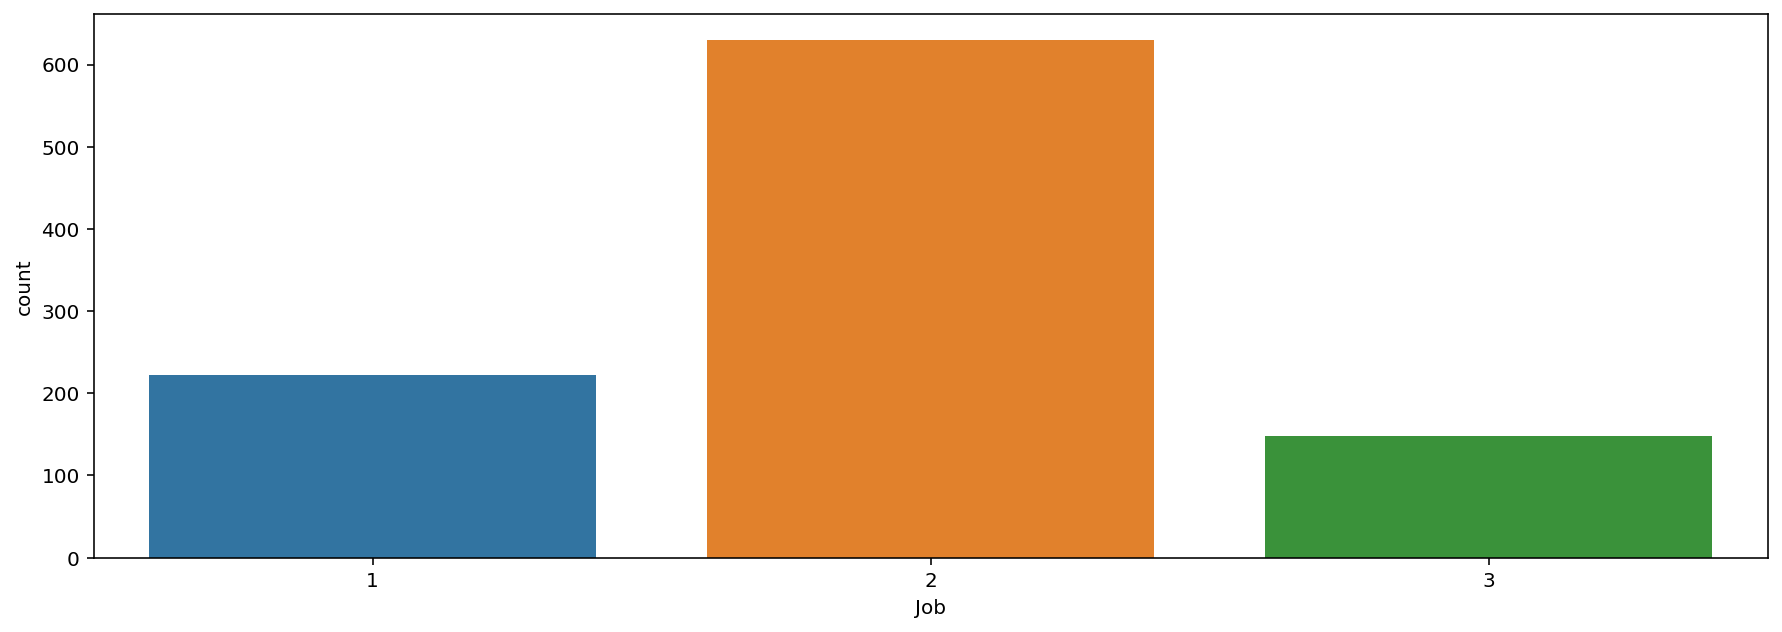

      Housing  Ratio
own       713   71.3
rent      179   17.9
free      108   10.8




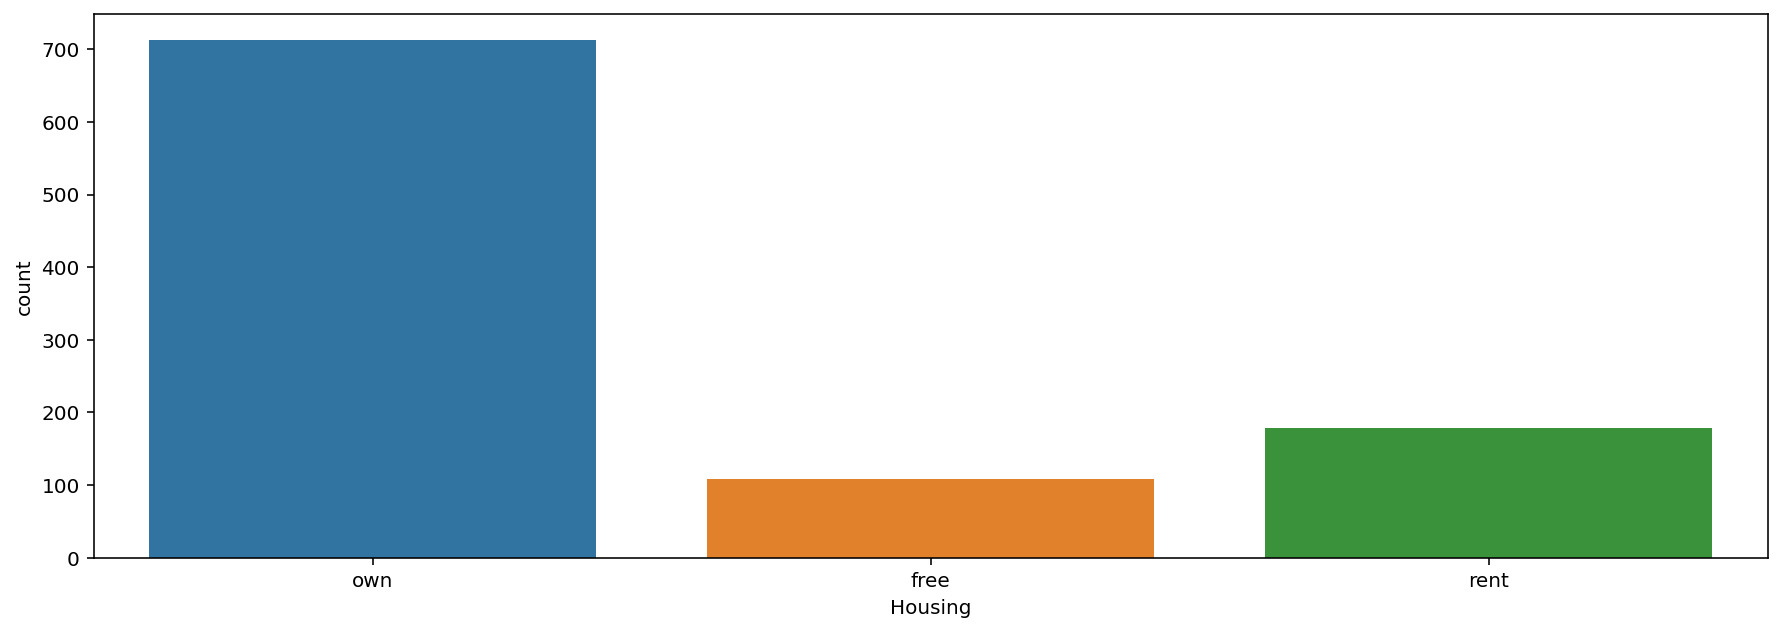

          Saving accounts  Ratio
little                786   78.6
rich                  111   11.1
moderate              103   10.3




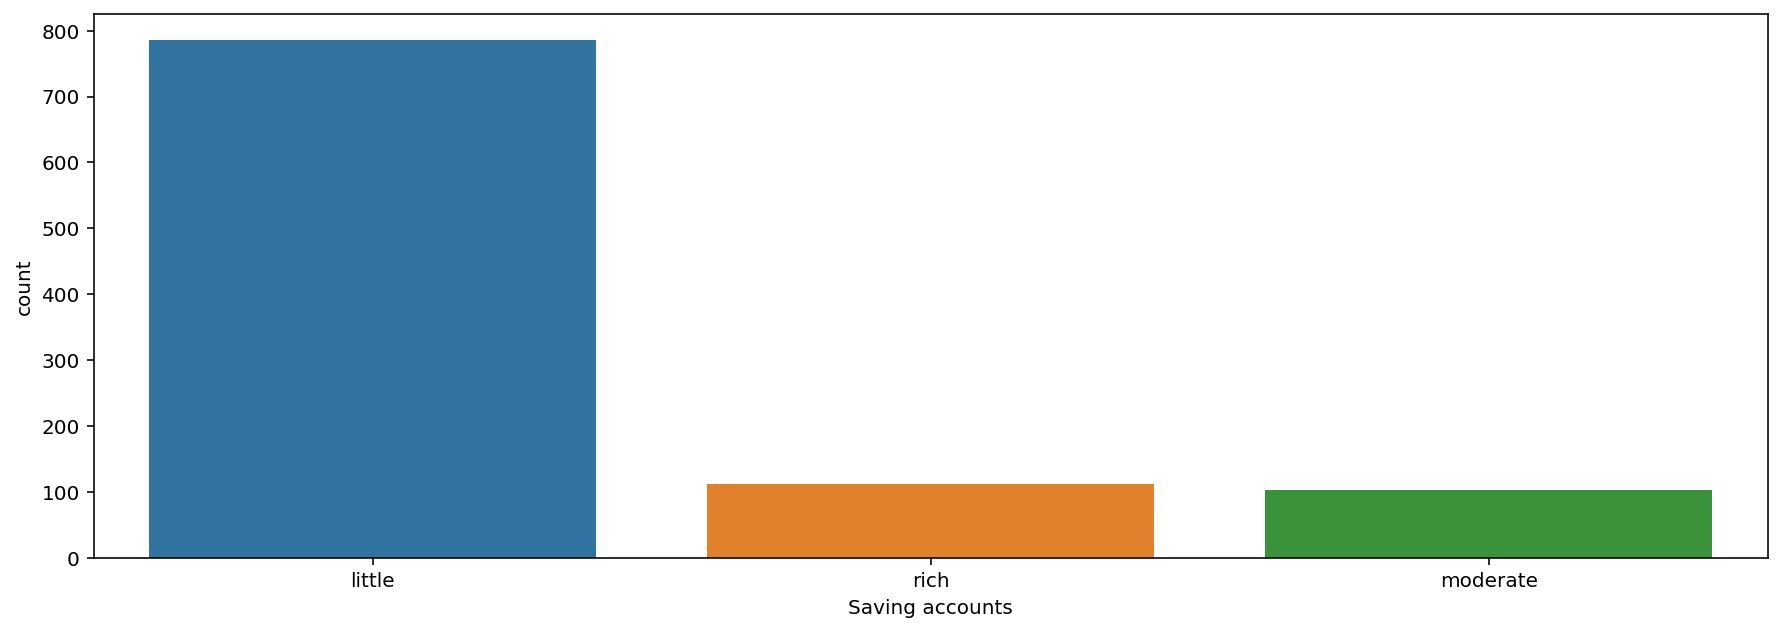

          Checking account  Ratio
little                 668   66.8
moderate               269   26.9
rich                    63    6.3




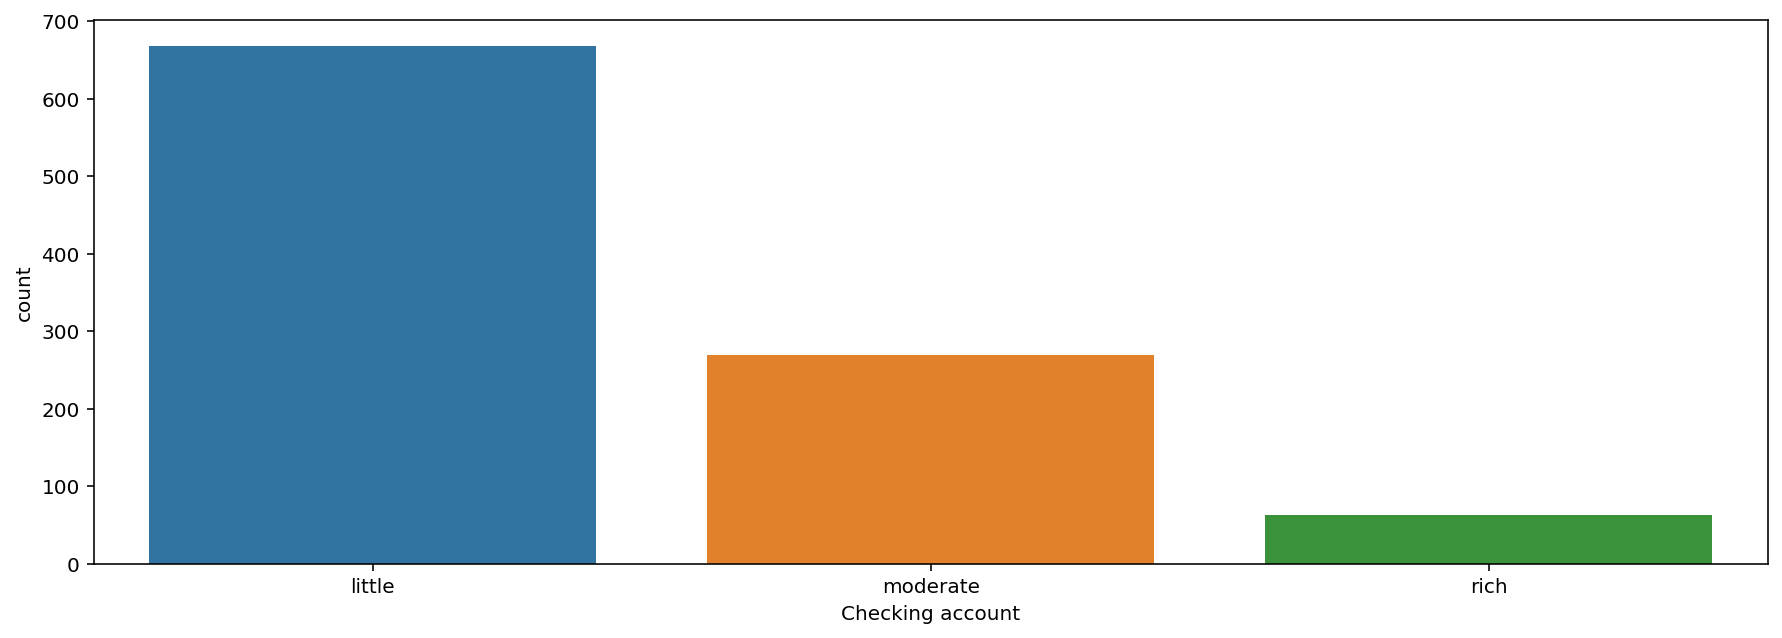

                     Purpose  Ratio
car                      337   33.7
radio/TV                 280   28.0
furniture/equipment      181   18.1
business                  97    9.7
education                 59    5.9
repairs                   22    2.2
domestic appliances       12    1.2
vacation/others           12    1.2




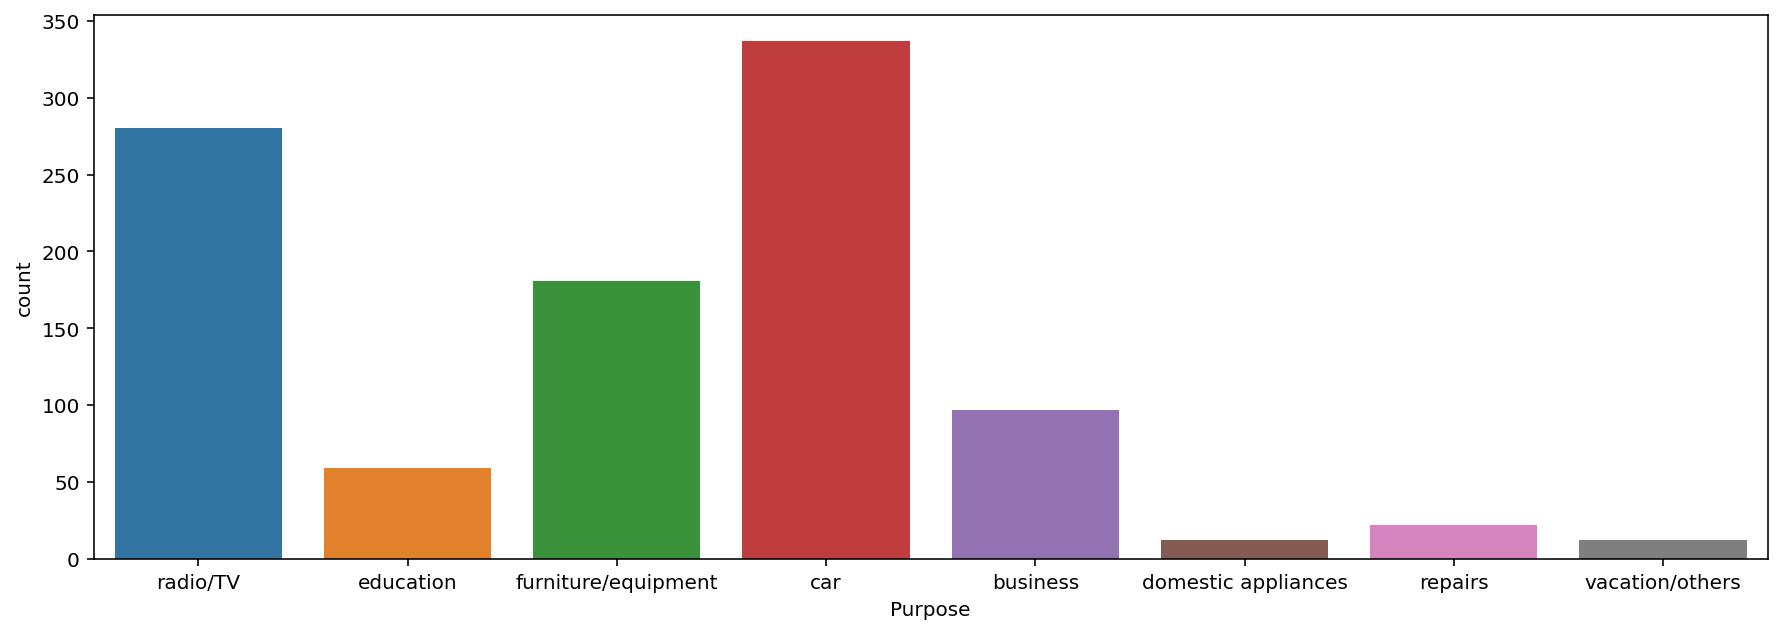

      Risk  Ratio
good   700   70.0
bad    300   30.0




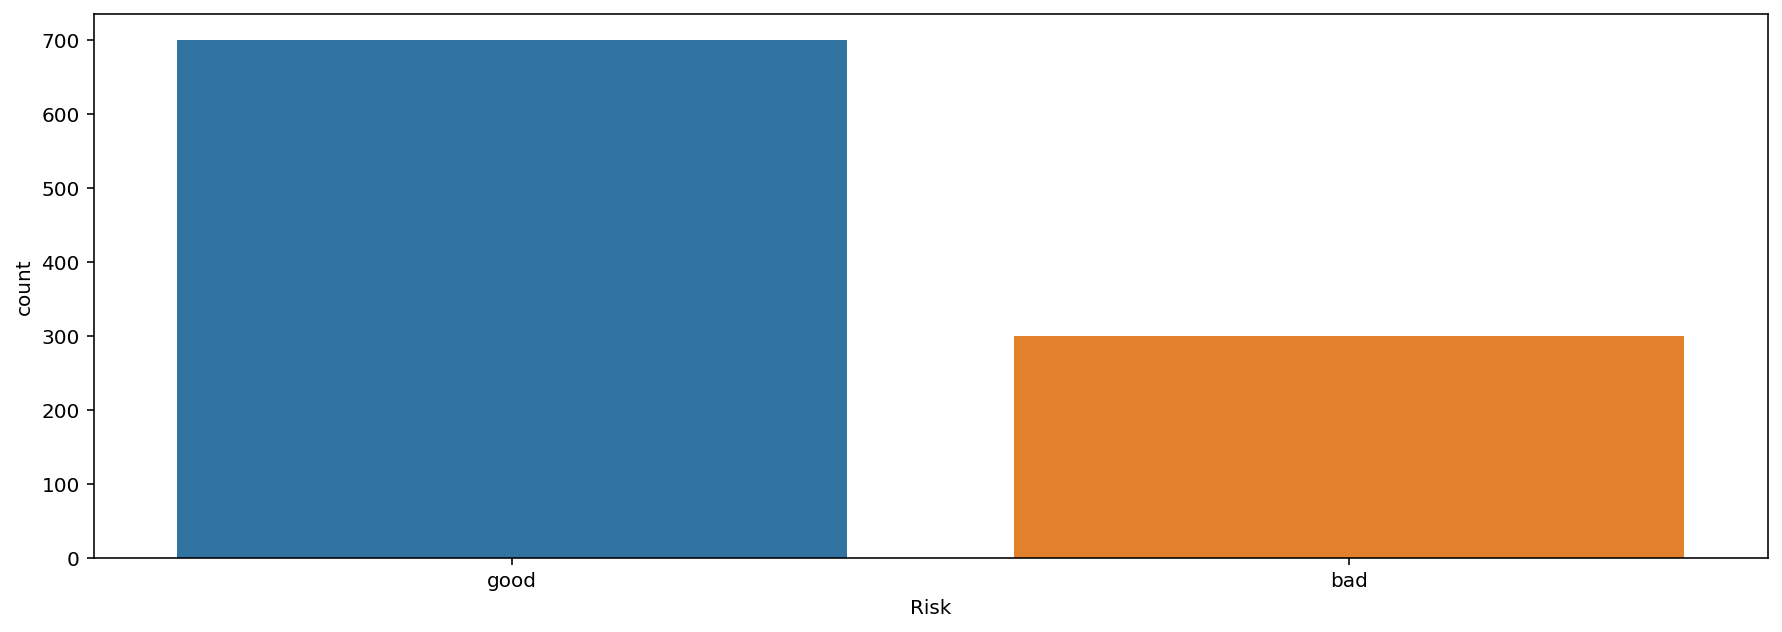

In [24]:
#Kategorik degiskenler hakkında ozet bilgiler
def cats_summary(data):
    cats_names = [col for col in data.columns if len(data[col].unique()) < 10 ]
    for var in cats_names:
        print(pd.DataFrame({var: data[var].value_counts(),
                            "Ratio": 100 * data[var].value_counts() / len(data)}), end="\n\n\n")
        import matplotlib.pyplot as plt
        fig, ax = plt.subplots(figsize=(15, 5)) 
        sns.countplot(x=var, data=data)
        plt.show()


cats_summary(df)

In [25]:
# Önceki kod ile:
num_cols = [col for col in df.columns if df[col].dtypes != 'O' and
            col not in "Risk" and
            col not in "more_cat_cols"]
num_cols

['Age',
 'Job',
 'Credit amount',
 'Duration',
 'faiz_yuzdesi',
 'toplam_borc',
 'faiz_tutari',
 'yas_sure',
 'ust_yas',
 'c_d',
 'd_a']

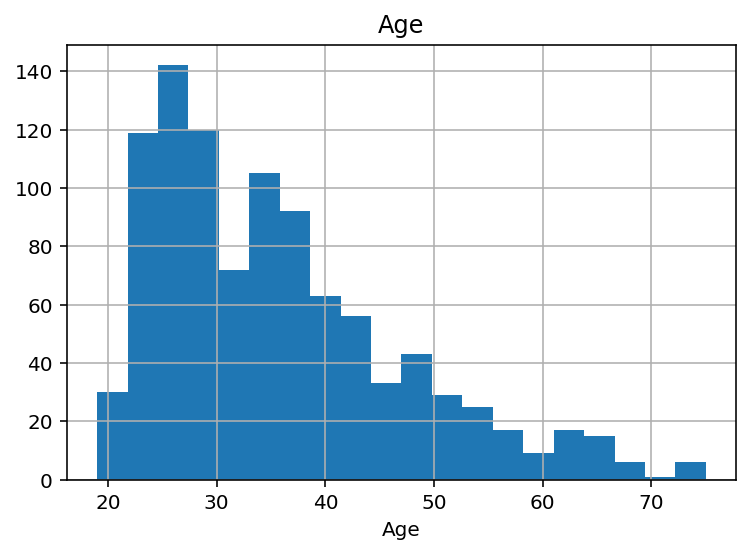

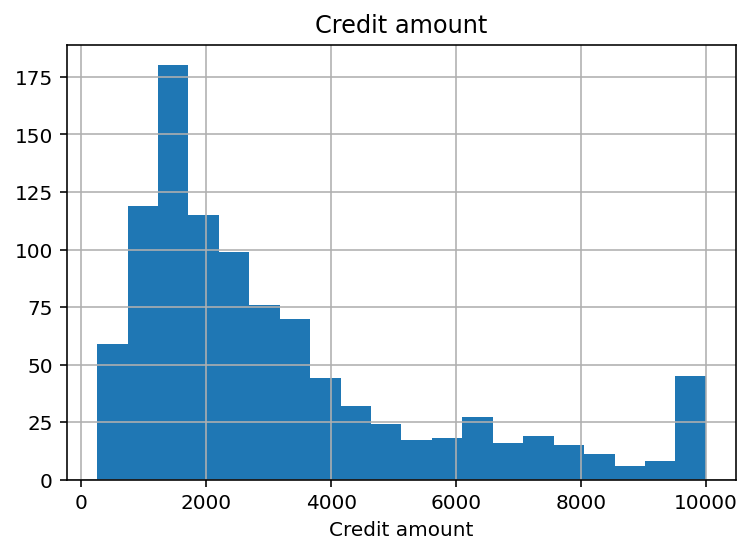

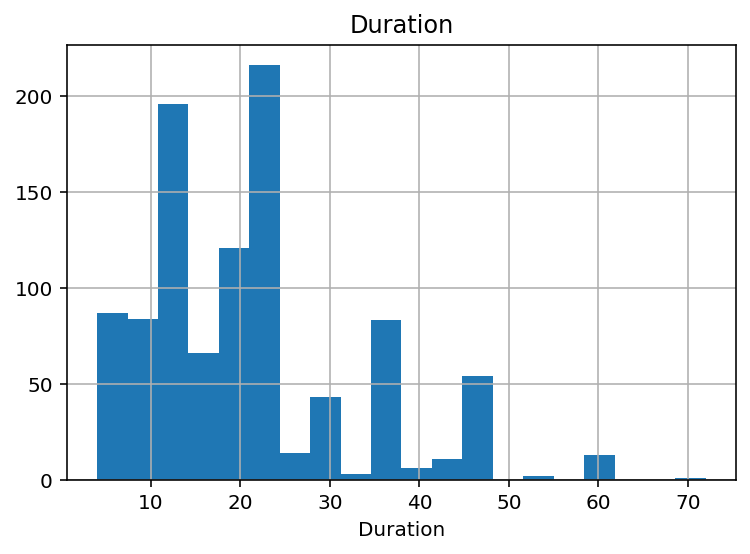

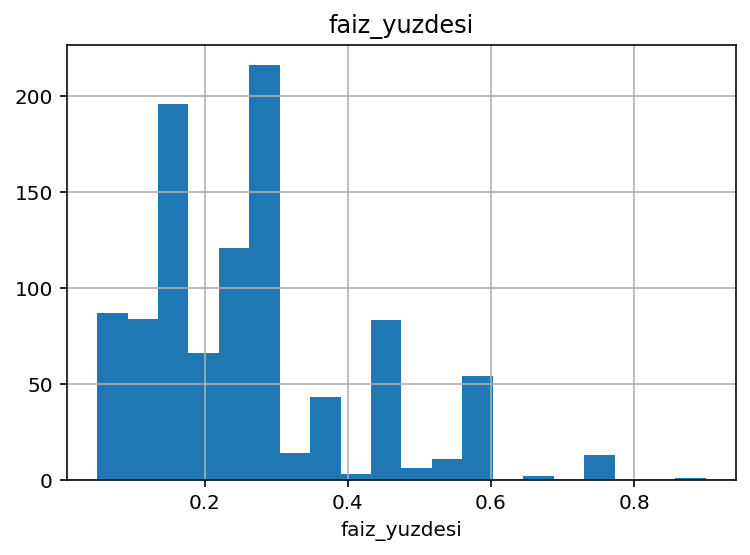

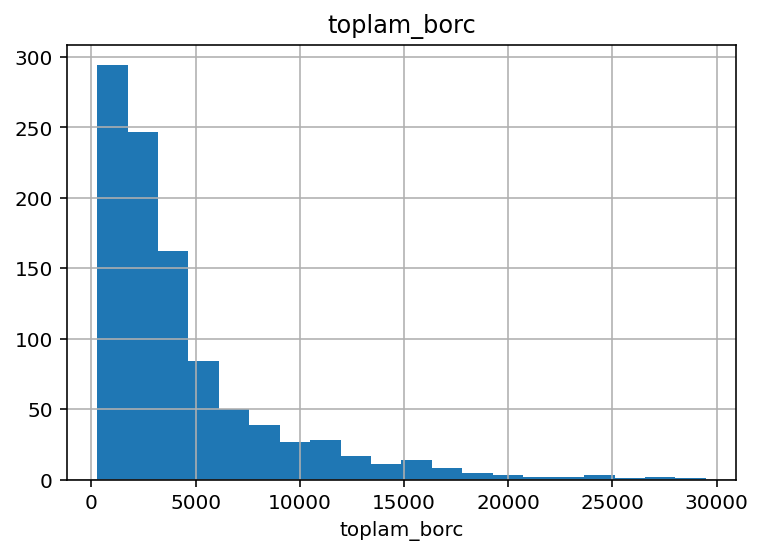

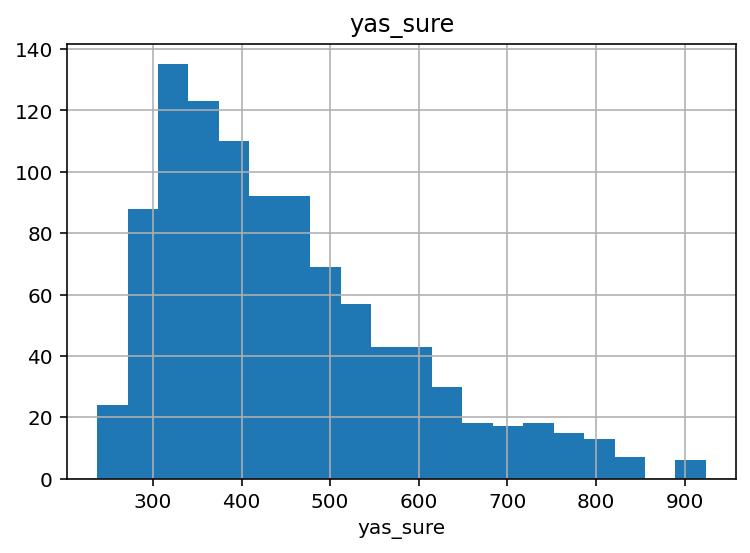

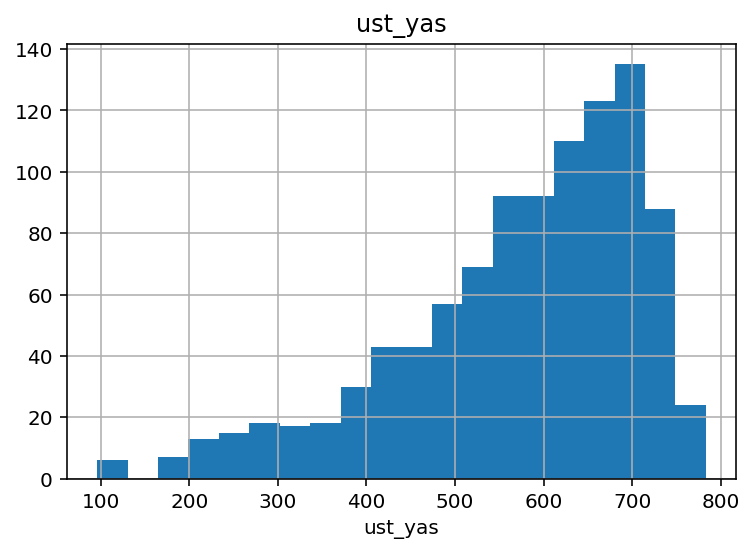

7 variables have been plotted


In [26]:
#Sayısal degiskenlerin grafiginin cizdirilmesi
def hist_for_nums(data, numeric_cols):
    col_counter = 0
    data = data.copy()
    for col in numeric_cols:
        data[col].hist(bins=20)
        plt.xlabel(col)
        plt.title(col)
        plt.show()
        col_counter += 1
    print(col_counter, "variables have been plotted")


hist_for_nums(df, ['Age',  'Credit amount', 'Duration',"faiz_yuzdesi","toplam_borc","yas_sure","ust_yas"])

In [27]:
#Bagımlı degiskene gore sayısal degiskenlerin ortalama degerleri
def target_summary_with_nums(data, target):
    num_names = [col for col in data.columns if len(data[col].unique()) > 5
                 and df[col].dtypes != 'O']


    for var in num_names:
        print(df.groupby(target).agg({var: np.mean}), end="\n\n\n")


target_summary_with_nums(df, "Risk")

            Age
Risk           
bad   33.963333
good  36.224286


      Credit amount
Risk               
bad     3695.243333
good    2938.585714


       Duration
Risk           
bad   24.860000
good  19.207143


      faiz_yuzdesi
Risk              
bad       0.310750
good      0.240089


      toplam_borc
Risk             
bad   5478.991292
good  3925.650554


      faiz_tutari
Risk             
bad   1540.142562
good   939.082540


        yas_sure
Risk            
bad   432.420000
good  453.898571


         ust_yas
Risk            
bad   587.580000
good  566.101429


                c_d
Risk               
bad   123269.170000
good   75215.472857


                d_a
Risk               
bad   139623.803333
good  107774.954286




In [28]:
#Enkod islemi
from sklearn.preprocessing import LabelEncoder
def one_hot_encoder(dataframe, category_freq=10, nan_as_category=False):
    categorical_cols = [col for col in dataframe.columns if len(dataframe[col].value_counts()) < category_freq
                        and dataframe[col].dtypes == 'O' ]

    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, dummy_na=nan_as_category, drop_first=True)

    return dataframe

#label encoding
df = pd.get_dummies(df, columns=["Job"], drop_first=True )

df = one_hot_encoder(df)

df.head()

,Age,Credit amount,Duration,faiz_yuzdesi,toplam_borc,faiz_tutari,yas_sure,ust_yas,c_d,d_a,...,Checking account_moderate,Checking account_rich,Purpose_car,Purpose_domestic appliances,Purpose_education,Purpose_furniture/equipment,Purpose_radio/TV,Purpose_repairs,Purpose_vacation/others,Risk_good
0,67.0,1169.0,6,0.075,1256.675,87.675,810.0,210.0,7014,78323,...,0,0,0,0,0,0,1,0,0,1
1,22.0,5951.0,48,0.600,9521.600,3570.600,312.0,708.0,285648,130922,...,1,0,0,0,0,0,1,0,0,0
2,49.0,2096.0,12,0.150,2410.400,314.400,600.0,420.0,25152,102704,...,0,0,0,0,1,0,0,0,0,1
3,45.0,7882.0,42,0.525,12020.050,4138.050,582.0,438.0,331044,354690,...,0,0,0,0,0,1,0,0,0,1
4,53.0,4870.0,24,0.300,6331.000,1461.000,660.0,360.0,116880,258110,...,0,0,1,0,0,0,0,0,0,0


In [29]:
#Standartlastırma(carpıklıkların giderilmesi)
from sklearn.preprocessing import RobustScaler
for i in ["Age","Credit amount","Duration","toplam_borc","faiz_tutari","yas_sure" ,"ust_yas"]:
    transformer = RobustScaler().fit(df[[i]])
    df[i] = transformer.transform(df[[i]])
    
df.head()

,Age,Credit amount,Duration,faiz_yuzdesi,toplam_borc,faiz_tutari,yas_sure,ust_yas,c_d,d_a,...,Checking account_moderate,Checking account_rich,Purpose_car,Purpose_domestic appliances,Purpose_education,Purpose_furniture/equipment,Purpose_radio/TV,Purpose_repairs,Purpose_vacation/others,Risk_good
0,2.266667,-0.441354,-1.0,0.075,-0.432354,-0.409057,2.183333,-2.183333,7014,78323,...,0,0,0,0,0,0,1,0,0,1
1,-0.733333,1.393114,2.5,0.600,1.776080,3.032908,-0.583333,0.583333,285648,130922,...,1,0,0,0,0,0,1,0,0,0
2,1.066667,-0.085739,-0.5,0.150,-0.124072,-0.184999,1.016667,-1.016667,25152,102704,...,0,0,0,0,1,0,0,0,0,1
3,0.800000,2.133883,2.0,0.525,2.443680,3.593685,0.916667,-0.916667,331044,354690,...,0,0,0,0,0,1,0,0,0,1
4,1.333333,0.978421,0.5,0.300,0.923534,0.948117,1.350000,-1.350000,116880,258110,...,0,0,1,0,0,0,0,0,0,0


In [30]:
df.columns

Index(['Age', 'Credit amount', 'Duration', 'faiz_yuzdesi', 'toplam_borc',
       'faiz_tutari', 'yas_sure', 'ust_yas', 'c_d', 'd_a', 'Job_2', 'Job_3',
       'Sex_male', 'Housing_own', 'Housing_rent', 'Saving accounts_moderate',
       'Saving accounts_rich', 'Checking account_moderate',
       'Checking account_rich', 'Purpose_car', 'Purpose_domestic appliances',
       'Purpose_education', 'Purpose_furniture/equipment', 'Purpose_radio/TV',
       'Purpose_repairs', 'Purpose_vacation/others', 'Risk_good'],
      dtype='object')

In [31]:
#df = df.drop(["Purpose_domestic appliances","Purpose_repairs","Purpose_vacation/others","Purpose_vacation/others","Purpose_education","Checking account_rich"] , axis = 1)




In [32]:
#Risk degiskeninin dusurulmesi
X = df.drop('Risk_good', axis=1)
y = df[["Risk_good"]]

#Veri setinin egitim ve test seti olarak bolunmesi
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20,stratify=y, random_state=46)



# LightGBM

#Model olusturma
lgbm = LGBMClassifier(random_state=12345)
cross_val_score(lgbm, X, y, cv=10).mean()


0.688

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    7.6s finished


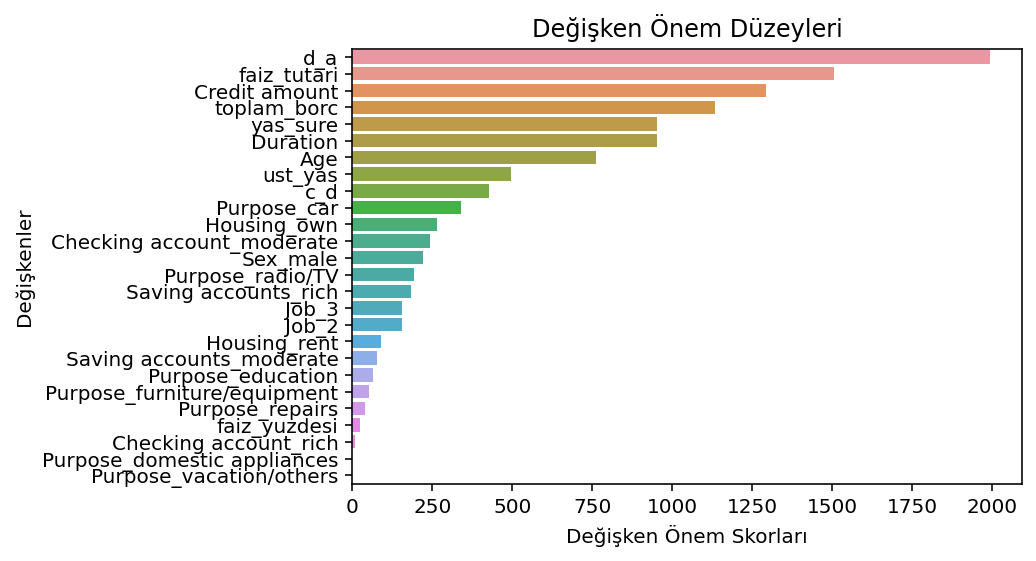

In [33]:

# model tuning
lgbm_params = {"learning_rate": [0.01, 0.1],
               "n_estimators": [500, 1000],
               "max_depth": [3, 5]}

#GridSearchCV hesaplanması
gs_cv = GridSearchCV(lgbm,
                     lgbm_params,
                     cv=5,
                     n_jobs=-1,
                     verbose=2).fit(X_train, y_train)

#En iyi parametrelerle model kurma
lgbm_tuned = LGBMClassifier(**gs_cv.best_params_).fit(X, y)
cross_val_score(lgbm_tuned, X_test, y_test, cv=10).mean()


feature_imp = pd.Series(lgbm_tuned.feature_importances_,
                        index=X.columns).sort_values(ascending=False)

#Degisken onem duzeylerinin grafiksel gosterimi
sns.barplot(x=feature_imp, y=feature_imp.index)
plt.xlabel('Değişken Önem Skorları')
plt.ylabel('Değişkenler')
plt.title("Değişken Önem Düzeyleri")
plt.show()

#cv islemleri(caprazlama)
kfold = KFold(n_splits=10, random_state=123456)
cv_results = cross_val_score(LGBMClassifier(), X_train, y_train, cv=kfold, scoring="accuracy")

In [34]:
#sınıflandırma sonucu
cv_results.mean()

0.68875